In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from cvnn import layers 

2023-09-16 08:05:41.343353: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-16 08:05:42.147563: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# data_loc = '/home/saumya/Documents/NRSC internship/Dataset/MRSDP_SLC_DATA/EOS4_FRS1_SLC/Pauli_Lee5X5/'
# file_loc = '/home/saumya/Documents/NRSC internship/Dataset/MRSDP_SLC_DATA/EOS4_FRS1_SLC/scene_HH/'

In [3]:
# file_loc = '/home/saumya/Documents/NRSC SAR CVNN/Data-sets/MRSDP_SLC_DATA/EOS4_FRS1_SLC/scene_HH/'
# data_loc = '/home/saumya/Documents/NRSC SAR CVNN/Data-sets/MRSDP_SLC_DATA/EOS4_FRS1_SLC/Pauli_Lee5X5/'

In [4]:
file_loc = 'EOS4_FRS1_SLC/scene_HH/'
data_loc = 'EOS4_FRS1_SLC/Pauli_Lee5X5/'

In [5]:
mask = np.load(data_loc+'mask.npy')

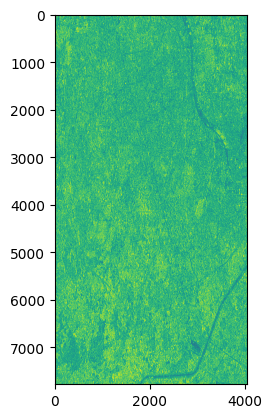

In [6]:
plt.imshow(mask)

In [7]:
inputs = np.load(file_loc+'input.npy')

In [8]:
import patchify as pat

In [9]:
img_dim  = 128

In [10]:
patches_inp = pat.patchify(inputs, (img_dim, img_dim), step=img_dim)
patches_mask = pat.patchify(mask, (img_dim,img_dim), step=img_dim)

In [11]:
patches_mask.shape[0]*patches_mask.shape[1]

1860

In [12]:
patches_inp.shape

(60, 31, 128, 128)

In [13]:
input_img = np.reshape(patches_inp, [patches_mask.shape[0]*patches_mask.shape[1], img_dim, img_dim])
mask_img = np.reshape(patches_mask, [patches_mask.shape[0]*patches_mask.shape[1], img_dim, img_dim])

In [14]:
input_img = np.expand_dims(input_img, -1)
mask_img = np.expand_dims(mask_img, -1)

In [15]:
input_img.dtype

dtype('complex64')

In [16]:
from keras.utils import to_categorical
classes = np.unique(mask_img[0]).astype(int)
mask_cat = to_categorical(mask_img)

In [17]:
norm = np.abs(input_img.max())
input_img_norm = (input_img/norm).astype(np.complex64)

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_img_norm, mask_cat, test_size = 0.25, random_state = 42, shuffle=True)

In [19]:
mask_cat[0].shape

(128, 128, 4)

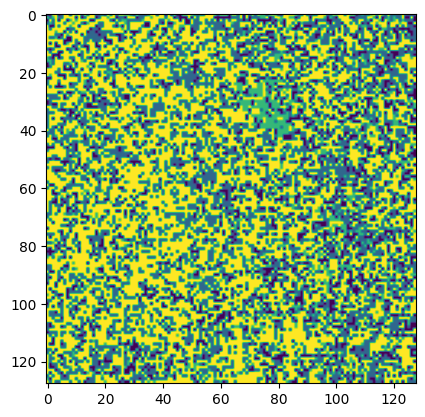

In [20]:
plt.imshow(mask_img[25])

In [21]:
X_train.shape[1:]

(128, 128, 1)

In [22]:
input_shape = (X_train.shape[1:])
# input_shape = np.array(input_shape).reshape(-1, 256, 256, 1)
dtype  = tf.complex64

In [23]:
from keras.layers import Activation
from cvnn.activations import cart_softmax, cart_relu, cart_leaky_relu

In [24]:
def _downsample_cvnn(inputs, units, dtype=dtype):
    c0 = layers.ComplexConv2D(units, kernel_size=3, activation='cart_leaky_relu', kernel_initializer='ComplexHeNormal', padding='same', dtype = dtype)(inputs)
    c0 = layers.ComplexDropout(0.2)(c0)
    c0 = layers.ComplexBatchNormalization(dtype=dtype)(c0)  
    c0 = Activation(cart_leaky_relu)(c0)
    # c0 = layers.ComplexBatchNormalization(dtype=dtype)(c0)
    c1 = layers.ComplexConv2D(units, kernel_size=3, activation='cart_leaky_relu', kernel_initializer='ComplexHeNormal', padding='same', dtype= dtype)(c0)
    c1 = layers.ComplexDropout(0.2)(c1)
    c1 = layers.ComplexBatchNormalization(dtype=dtype)(c1)  
    c1 = Activation(cart_leaky_relu)(c1)
    p1 = layers.ComplexAvgPooling2D((2,2), dtype=dtype)(c1)
    # p1 = layers.ComplexDropout(rate=0.3, dtype=dtype)(p1)
    return (c0, c1, p1) 

In [25]:
# def _downsample_cvnn(inputs, units):
#     c0 = layers.ComplexConv2D(units, activation='cart_relu', kernel_size=3)(inputs)
#     c1 = layers.ComplexConv2D(units, activation='cart_relu', kernel_size=3)(c0)
#     c2 = layers.ComplexMaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(c1)
#     return c0, c1, c2

In [26]:
def _upsample_cvnn(in1, in2, units, dtype = dtype):
    # print(in1.shape)
    t01 = layers.ComplexConv2DTranspose(units, (2, 2), strides=(2,2), activation='cart_leaky_relu', dtype=dtype, padding='same')(in1)
    t01 = layers.ComplexDropout(0.2)(t01)
    t01 = layers.ComplexBatchNormalization(dtype=dtype)(t01)
    t01 = Activation(cart_leaky_relu)(t01)
    
    # crop01 = tf.keras.layers.Cropping2D(cropping=(crop, crop))(in2)
    # t01 = layers.ComplexUpSampling2D(size=4, interpolation='bilinear', data_format='channels_first')(t01)
    # print(t01.shape)
    concat01 = tf.keras.layers.concatenate([t01, in2], axis=-1)
    # concat01 = layers.ComplexBatchNormalization(dtype=dtype)(concat01)  
    # concat01 = Activation(cart_leaky_relu)(concat01)
    out1 = layers.ComplexConv2D(units, activation='cart_leaky_relu', kernel_initializer='ComplexHeNormal',kernel_size=3, dtype=dtype, padding='same')(concat01)
    out1 = layers.ComplexDropout(rate=0.2, dtype=dtype)(out1)
    out1 = layers.ComplexBatchNormalization(dtype=dtype)(out1)  
    out1 = Activation(cart_leaky_relu)(out1)

    out2 = layers.ComplexConv2D(units, activation='cart_leaky_relu', kernel_initializer='ComplexHeNormal',kernel_size=3, dtype=dtype, padding ='same')(out1)
    out2 = layers.ComplexDropout(rate = 0.2, dtype=dtype)(out2)
    out2 = layers.ComplexBatchNormalization(dtype=dtype)(out2)  
    out2 = Activation(cart_leaky_relu)(out2)    
    
    return out1, out2

In [27]:
input_shape

(128, 128, 1)

In [28]:
from cvnn import losses
from keras.optimizers import Adam, Lion, AdamW

In [29]:
# losses.ComplexWeightedAverageCrossEntropyIgnoreUnlabeled

In [30]:
from cvnn.metrics import ComplexCategoricalAccuracy, ComplexAverageAccuracy, ComplexPrecision, ComplexRecall

/home/nirmala/anaconda3/envs/saumya/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [31]:
def cvnn_unet(dtype = tf.complex64):
    # tf.random.set_seed(1)
    inputs = layers.complex_input(shape=input_shape, dtype=dtype)

    c0, c1, c2 = _downsample_cvnn(inputs,32)
    c3, c4, c5 = _downsample_cvnn(c2, 64)
    c6, c7, c8 = _downsample_cvnn(c5, 128)
    c9, c10, c11 = _downsample_cvnn(c8, 256)
    # c61, c62, c63 = _downsample_cvnn(c11, 512) 

    
    c12 = layers.ComplexConv2D(256, activation='cart_leaky_relu', kernel_size=3, padding='same')(c11)
    c13 = layers.ComplexConv2D(512, activation='cart_leaky_relu', kernel_size=3, padding='same')(c12)


    # c64, c65 = _upsample_cvnn(c13, c62, 512, dtype)
    c14, c15 = _upsample_cvnn(c13, c10, 256, dtype)
    c16, c17 = _upsample_cvnn(c15, c7, 128, dtype)
    c18, c19 = _upsample_cvnn(c17, c4, 64, dtype)
    c20, c21 = _upsample_cvnn(c19, c1, 32, dtype)

    outputs = layers.ComplexConv2D(4, kernel_size=1, activation = 'softmax_real_with_avg', dtype=dtype)(c21)
    # outputs = layers.ComplexConv2D(1, kernel_size=1)(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="u-net-cvnn")
    model.compile(loss=losses.ComplexAverageCrossEntropy(), optimizer=Lion(learning_rate=1e-4), metrics=[ComplexCategoricalAccuracy(name='accuracy'),
                           ComplexAverageAccuracy(name='average_accuracy'),
                           ComplexPrecision(name='precision'),
                           ComplexRecall(name='recall')
                           ])
    return model


In [32]:
from keras.callbacks import ModelCheckpoint

In [33]:
path = 'home/saumya/Model_CVNN/'

cp_callback = ModelCheckpoint(filepath=path, save_weights_only=False, verbose=1)
callbacks=[cp_callback]

k = cvnn_unet(tf.complex64)
print(k.summary())

2023-09-16 08:05:51.593971: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30813 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


Model: "u-net-cvnn"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (ComplexInput)      [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 complex_conv2d (ComplexCon  (None, 128, 128, 32)         640       ['input_1[0][0]']             
 v2D)                                                                                             
                                                                                                  
 complex_dropout (ComplexDr  (None, 128, 128, 32)         0         ['complex_conv2d[0][0]']      
 opout)                                                                                           
                                                                                         

In [34]:
# model = tf.keras.models.Sequential()
# model.add(complex_layers.ComplexInput(input_shape=input_shape + (3,)))
# model.add(complex_layers.ComplexConv2D(32, (2, 2), activation='cart_leaky_relu', padding='same'))
# model.add(complex_layers.ComplexMaxPooling2D((2, 2)))
# model.add(complex_layers.ComplexConv2D(64, (2, 2), activation='cart_leaky_relu', padding='same'))
# model.add(complex_layers.ComplexMaxPooling2D((2, 2)))
# model.add(complex_layers.ComplexConv2D(128, (2, 2), activation='cart_leaky_relu', padding='same'))
# model.add(complex_layers.ComplexMaxPooling2D((2, 2)))
# model.add(complex_layers.ComplexConv2D(256, (2, 2), activation='cart_leaky_relu', padding='same'))
# model.add(complex_layers.ComplexMaxPooling2D((2, 2)))
# model.add(complex_layers.ComplexFlatten())

In [35]:
    # config = tf.ConfigProto()
    # config.gpu_options.allow_growth = True
    # sess = tf.Session(config=config)

In [36]:
history = k.fit(X_train, y_train, epochs=200, validation_split=0.2, batch_size=32, callbacks=[cp_callback])

2023-09-16 08:05:56.000938: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 146276352 exceeds 10% of free system memory.
2023-09-16 08:05:56.471768: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 292552704 exceeds 10% of free system memory.
2023-09-16 08:05:56.845547: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 146276352 exceeds 10% of free system memory.
2023-09-16 08:05:56.969888: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 292552704 exceeds 10% of free system memory.


Epoch 1/200


2023-09-16 08:06:32.323341: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-16 08:06:34.135035: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x7b90f10
2023-09-16 08:06:55.485641: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7424002150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-16 08:06:55.485772: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2023-09-16 08:06:55.504851: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-16 08:06:56.133801: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


35/35 [==============================] - ETA: 0s - loss: 1.4822 - accuracy: 0.3422 - average_accuracy: 0.2547 - precision: 0.3477 - recall: 0.0552 

2023-09-16 08:30:24.330951: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 73138176 exceeds 10% of free system memory.



Epoch 1: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1669s 47s/step - loss: 1.4822 - accuracy: 0.3422 - average_accuracy: 0.2547 - precision: 0.3477 - recall: 0.0552 - val_loss: 1.3610 - val_accuracy: 0.5420 - val_average_accuracy: 0.2499 - val_precision: 0.5810 - val_recall: 9.6475e-05
Epoch 2/200
35/35 [==============================] - ETA: 0s - loss: 1.3608 - accuracy: 0.4455 - average_accuracy: 0.2581 - precision: 0.4661 - recall: 0.0699 
Epoch 2: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1650s 47s/step - loss: 1.3608 - accuracy: 0.4455 - average_accuracy: 0.2581 - precision: 0.4661 - recall: 0.0699 - val_loss: 1.2966 - val_accuracy: 0.5445 - val_average_accuracy: 0.2497 - val_precision: 0.6856 - val_recall: 0.0011
Epoch 3/200
35/35 [==============================] - ETA: 0s - loss: 1.2922 - accuracy: 0.4884 - average_accuracy: 0.2577 - precision: 0.5523 - recall: 0.0996 
Epoch 3: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1550s 44s/step - loss: 1.2922 - accuracy: 0.4884 - average_accuracy: 0.2577 - precision: 0.5523 - recall: 0.0996 - val_loss: 1.2310 - val_accuracy: 0.5441 - val_average_accuracy: 0.2495 - val_precision: 0.6409 - val_recall: 0.0030
Epoch 4/200
35/35 [==============================] - ETA: 0s - loss: 1.2513 - accuracy: 0.5116 - average_accuracy: 0.2562 - precision: 0.5923 - recall: 0.1475 
Epoch 4: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1486s 43s/step - loss: 1.2513 - accuracy: 0.5116 - average_accuracy: 0.2562 - precision: 0.5923 - recall: 0.1475 - val_loss: 1.3661 - val_accuracy: 0.5445 - val_average_accuracy: 0.2497 - val_precision: 0.5518 - val_recall: 0.3120
Epoch 5/200
35/35 [==============================] - ETA: 0s - loss: 1.2217 - accuracy: 0.5247 - average_accuracy: 0.2552 - precision: 0.6016 - recall: 0.2050 
Epoch 5: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1519s 44s/step - loss: 1.2217 - accuracy: 0.5247 - average_accuracy: 0.2552 - precision: 0.6016 - recall: 0.2050 - val_loss: 1.2452 - val_accuracy: 0.5412 - val_average_accuracy: 0.2495 - val_precision: 0.5561 - val_recall: 0.2347
Epoch 6/200
35/35 [==============================] - ETA: 0s - loss: 1.1999 - accuracy: 0.5330 - average_accuracy: 0.2540 - precision: 0.6048 - recall: 0.2492 
Epoch 6: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1476s 42s/step - loss: 1.1999 - accuracy: 0.5330 - average_accuracy: 0.2540 - precision: 0.6048 - recall: 0.2492 - val_loss: 1.3682 - val_accuracy: 0.2937 - val_average_accuracy: 0.2462 - val_precision: 0.5645 - val_recall: 0.0104
Epoch 7/200
35/35 [==============================] - ETA: 0s - loss: 1.1808 - accuracy: 0.5377 - average_accuracy: 0.2529 - precision: 0.6075 - recall: 0.2780 
Epoch 7: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1476s 42s/step - loss: 1.1808 - accuracy: 0.5377 - average_accuracy: 0.2529 - precision: 0.6075 - recall: 0.2780 - val_loss: 1.3640 - val_accuracy: 0.3228 - val_average_accuracy: 0.2529 - val_precision: 0.5813 - val_recall: 0.0301
Epoch 8/200
35/35 [==============================] - ETA: 0s - loss: 1.1664 - accuracy: 0.5409 - average_accuracy: 0.2522 - precision: 0.6152 - recall: 0.2906 
Epoch 8: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1465s 42s/step - loss: 1.1664 - accuracy: 0.5409 - average_accuracy: 0.2522 - precision: 0.6152 - recall: 0.2906 - val_loss: 1.2407 - val_accuracy: 0.5296 - val_average_accuracy: 0.2516 - val_precision: 0.6455 - val_recall: 0.0558
Epoch 9/200
35/35 [==============================] - ETA: 0s - loss: 1.1544 - accuracy: 0.5427 - average_accuracy: 0.2519 - precision: 0.6202 - recall: 0.3027 
Epoch 9: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1466s 42s/step - loss: 1.1544 - accuracy: 0.5427 - average_accuracy: 0.2519 - precision: 0.6202 - recall: 0.3027 - val_loss: 1.2109 - val_accuracy: 0.5448 - val_average_accuracy: 0.2507 - val_precision: 0.6717 - val_recall: 0.0612
Epoch 10/200
35/35 [==============================] - ETA: 0s - loss: 1.1456 - accuracy: 0.5444 - average_accuracy: 0.2515 - precision: 0.6250 - recall: 0.3140 
Epoch 10: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1467s 42s/step - loss: 1.1456 - accuracy: 0.5444 - average_accuracy: 0.2515 - precision: 0.6250 - recall: 0.3140 - val_loss: 1.2533 - val_accuracy: 0.5193 - val_average_accuracy: 0.2551 - val_precision: 0.6371 - val_recall: 0.0673
Epoch 11/200
35/35 [==============================] - ETA: 0s - loss: 1.1378 - accuracy: 0.5458 - average_accuracy: 0.2510 - precision: 0.6298 - recall: 0.3230 
Epoch 11: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1472s 42s/step - loss: 1.1378 - accuracy: 0.5458 - average_accuracy: 0.2510 - precision: 0.6298 - recall: 0.3230 - val_loss: 1.2233 - val_accuracy: 0.5431 - val_average_accuracy: 0.2528 - val_precision: 0.6691 - val_recall: 0.0744
Epoch 12/200
35/35 [==============================] - ETA: 0s - loss: 1.1309 - accuracy: 0.5468 - average_accuracy: 0.2506 - precision: 0.6331 - recall: 0.3330 
Epoch 12: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1470s 42s/step - loss: 1.1309 - accuracy: 0.5468 - average_accuracy: 0.2506 - precision: 0.6331 - recall: 0.3330 - val_loss: 1.2205 - val_accuracy: 0.5456 - val_average_accuracy: 0.2539 - val_precision: 0.6600 - val_recall: 0.1090
Epoch 13/200
35/35 [==============================] - ETA: 0s - loss: 1.1249 - accuracy: 0.5471 - average_accuracy: 0.2505 - precision: 0.6375 - recall: 0.3369 
Epoch 13: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1484s 43s/step - loss: 1.1249 - accuracy: 0.5471 - average_accuracy: 0.2505 - precision: 0.6375 - recall: 0.3369 - val_loss: 1.1754 - val_accuracy: 0.5482 - val_average_accuracy: 0.2502 - val_precision: 0.6810 - val_recall: 0.1559
Epoch 14/200
35/35 [==============================] - ETA: 0s - loss: 1.1198 - accuracy: 0.5475 - average_accuracy: 0.2504 - precision: 0.6412 - recall: 0.3421 
Epoch 14: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1477s 42s/step - loss: 1.1198 - accuracy: 0.5475 - average_accuracy: 0.2504 - precision: 0.6412 - recall: 0.3421 - val_loss: 1.1386 - val_accuracy: 0.5483 - val_average_accuracy: 0.2500 - val_precision: 0.6783 - val_recall: 0.2369
Epoch 15/200
35/35 [==============================] - ETA: 0s - loss: 1.1157 - accuracy: 0.5478 - average_accuracy: 0.2503 - precision: 0.6441 - recall: 0.3454 
Epoch 15: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1475s 42s/step - loss: 1.1157 - accuracy: 0.5478 - average_accuracy: 0.2503 - precision: 0.6441 - recall: 0.3454 - val_loss: 1.1270 - val_accuracy: 0.5484 - val_average_accuracy: 0.2500 - val_precision: 0.6730 - val_recall: 0.2699
Epoch 16/200
35/35 [==============================] - ETA: 0s - loss: 1.1122 - accuracy: 0.5480 - average_accuracy: 0.2502 - precision: 0.6461 - recall: 0.3503 
Epoch 16: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1483s 42s/step - loss: 1.1122 - accuracy: 0.5480 - average_accuracy: 0.2502 - precision: 0.6461 - recall: 0.3503 - val_loss: 1.1186 - val_accuracy: 0.5483 - val_average_accuracy: 0.2500 - val_precision: 0.6885 - val_recall: 0.2647
Epoch 17/200
35/35 [==============================] - ETA: 0s - loss: 1.1092 - accuracy: 0.5481 - average_accuracy: 0.2502 - precision: 0.6486 - recall: 0.3533 
Epoch 17: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1465s 42s/step - loss: 1.1092 - accuracy: 0.5481 - average_accuracy: 0.2502 - precision: 0.6486 - recall: 0.3533 - val_loss: 1.1204 - val_accuracy: 0.5484 - val_average_accuracy: 0.2500 - val_precision: 0.6990 - val_recall: 0.2359
Epoch 18/200
35/35 [==============================] - ETA: 0s - loss: 1.1063 - accuracy: 0.5481 - average_accuracy: 0.2501 - precision: 0.6491 - recall: 0.3584 
Epoch 18: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1473s 42s/step - loss: 1.1063 - accuracy: 0.5481 - average_accuracy: 0.2501 - precision: 0.6491 - recall: 0.3584 - val_loss: 1.1163 - val_accuracy: 0.5484 - val_average_accuracy: 0.2501 - val_precision: 0.6997 - val_recall: 0.2428
Epoch 19/200
35/35 [==============================] - ETA: 0s - loss: 1.1031 - accuracy: 0.5482 - average_accuracy: 0.2501 - precision: 0.6503 - recall: 0.3614 
Epoch 19: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1468s 42s/step - loss: 1.1031 - accuracy: 0.5482 - average_accuracy: 0.2501 - precision: 0.6503 - recall: 0.3614 - val_loss: 1.1088 - val_accuracy: 0.5485 - val_average_accuracy: 0.2505 - val_precision: 0.6906 - val_recall: 0.2732
Epoch 20/200
35/35 [==============================] - ETA: 0s - loss: 1.1004 - accuracy: 0.5482 - average_accuracy: 0.2501 - precision: 0.6496 - recall: 0.3694 
Epoch 20: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1468s 42s/step - loss: 1.1004 - accuracy: 0.5482 - average_accuracy: 0.2501 - precision: 0.6496 - recall: 0.3694 - val_loss: 1.0955 - val_accuracy: 0.5484 - val_average_accuracy: 0.2502 - val_precision: 0.6446 - val_recall: 0.3967
Epoch 21/200
35/35 [==============================] - ETA: 0s - loss: 1.0980 - accuracy: 0.5483 - average_accuracy: 0.2501 - precision: 0.6521 - recall: 0.3687 
Epoch 21: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1468s 42s/step - loss: 1.0980 - accuracy: 0.5483 - average_accuracy: 0.2501 - precision: 0.6521 - recall: 0.3687 - val_loss: 1.1005 - val_accuracy: 0.5482 - val_average_accuracy: 0.2502 - val_precision: 0.6321 - val_recall: 0.4228
Epoch 22/200
35/35 [==============================] - ETA: 0s - loss: 1.0958 - accuracy: 0.5483 - average_accuracy: 0.2502 - precision: 0.6509 - recall: 0.3760 
Epoch 22: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1475s 42s/step - loss: 1.0958 - accuracy: 0.5483 - average_accuracy: 0.2502 - precision: 0.6509 - recall: 0.3760 - val_loss: 1.0978 - val_accuracy: 0.5484 - val_average_accuracy: 0.2501 - val_precision: 0.6305 - val_recall: 0.4351
Epoch 23/200
35/35 [==============================] - ETA: 0s - loss: 1.0942 - accuracy: 0.5484 - average_accuracy: 0.2504 - precision: 0.6529 - recall: 0.3755 
Epoch 23: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1459s 42s/step - loss: 1.0942 - accuracy: 0.5484 - average_accuracy: 0.2504 - precision: 0.6529 - recall: 0.3755 - val_loss: 1.0996 - val_accuracy: 0.5484 - val_average_accuracy: 0.2500 - val_precision: 0.6272 - val_recall: 0.4427
Epoch 24/200
35/35 [==============================] - ETA: 0s - loss: 1.0926 - accuracy: 0.5485 - average_accuracy: 0.2508 - precision: 0.6526 - recall: 0.3790 
Epoch 24: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1438s 41s/step - loss: 1.0926 - accuracy: 0.5485 - average_accuracy: 0.2508 - precision: 0.6526 - recall: 0.3790 - val_loss: 1.1066 - val_accuracy: 0.5484 - val_average_accuracy: 0.2501 - val_precision: 0.6217 - val_recall: 0.4513
Epoch 25/200
35/35 [==============================] - ETA: 0s - loss: 1.0907 - accuracy: 0.5486 - average_accuracy: 0.2513 - precision: 0.6523 - recall: 0.3829 
Epoch 25: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1435s 41s/step - loss: 1.0907 - accuracy: 0.5486 - average_accuracy: 0.2513 - precision: 0.6523 - recall: 0.3829 - val_loss: 1.0994 - val_accuracy: 0.5484 - val_average_accuracy: 0.2503 - val_precision: 0.6285 - val_recall: 0.4458
Epoch 26/200
35/35 [==============================] - ETA: 0s - loss: 1.0892 - accuracy: 0.5489 - average_accuracy: 0.2522 - precision: 0.6528 - recall: 0.3843 
Epoch 26: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1433s 41s/step - loss: 1.0892 - accuracy: 0.5489 - average_accuracy: 0.2522 - precision: 0.6528 - recall: 0.3843 - val_loss: 1.0994 - val_accuracy: 0.5485 - val_average_accuracy: 0.2503 - val_precision: 0.6260 - val_recall: 0.4506
Epoch 27/200
35/35 [==============================] - ETA: 0s - loss: 1.0876 - accuracy: 0.5492 - average_accuracy: 0.2534 - precision: 0.6534 - recall: 0.3853 
Epoch 27: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1427s 41s/step - loss: 1.0876 - accuracy: 0.5492 - average_accuracy: 0.2534 - precision: 0.6534 - recall: 0.3853 - val_loss: 1.1031 - val_accuracy: 0.5485 - val_average_accuracy: 0.2505 - val_precision: 0.6225 - val_recall: 0.4572
Epoch 28/200
35/35 [==============================] - ETA: 0s - loss: 1.0868 - accuracy: 0.5497 - average_accuracy: 0.2555 - precision: 0.6537 - recall: 0.3861 
Epoch 28: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1448s 41s/step - loss: 1.0868 - accuracy: 0.5497 - average_accuracy: 0.2555 - precision: 0.6537 - recall: 0.3861 - val_loss: 1.1141 - val_accuracy: 0.5485 - val_average_accuracy: 0.2505 - val_precision: 0.6143 - val_recall: 0.4688
Epoch 29/200
35/35 [==============================] - ETA: 0s - loss: 1.0854 - accuracy: 0.5501 - average_accuracy: 0.2572 - precision: 0.6520 - recall: 0.3912 
Epoch 29: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1433s 41s/step - loss: 1.0854 - accuracy: 0.5501 - average_accuracy: 0.2572 - precision: 0.6520 - recall: 0.3912 - val_loss: 1.1131 - val_accuracy: 0.5487 - val_average_accuracy: 0.2516 - val_precision: 0.6165 - val_recall: 0.4649
Epoch 30/200
35/35 [==============================] - ETA: 0s - loss: 1.0844 - accuracy: 0.5506 - average_accuracy: 0.2606 - precision: 0.6521 - recall: 0.3920 
Epoch 30: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1500s 43s/step - loss: 1.0844 - accuracy: 0.5506 - average_accuracy: 0.2606 - precision: 0.6521 - recall: 0.3920 - val_loss: 1.1076 - val_accuracy: 0.5490 - val_average_accuracy: 0.2532 - val_precision: 0.6201 - val_recall: 0.4623
Epoch 31/200
35/35 [==============================] - ETA: 0s - loss: 1.0828 - accuracy: 0.5511 - average_accuracy: 0.2635 - precision: 0.6523 - recall: 0.3935 
Epoch 31: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1410s 40s/step - loss: 1.0828 - accuracy: 0.5511 - average_accuracy: 0.2635 - precision: 0.6523 - recall: 0.3935 - val_loss: 1.1035 - val_accuracy: 0.5493 - val_average_accuracy: 0.2545 - val_precision: 0.6225 - val_recall: 0.4589
Epoch 32/200
35/35 [==============================] - ETA: 0s - loss: 1.0822 - accuracy: 0.5516 - average_accuracy: 0.2673 - precision: 0.6510 - recall: 0.3970 
Epoch 32: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1438s 41s/step - loss: 1.0822 - accuracy: 0.5516 - average_accuracy: 0.2673 - precision: 0.6510 - recall: 0.3970 - val_loss: 1.0916 - val_accuracy: 0.5502 - val_average_accuracy: 0.2598 - val_precision: 0.6315 - val_recall: 0.4457
Epoch 33/200
35/35 [==============================] - ETA: 0s - loss: 1.0814 - accuracy: 0.5522 - average_accuracy: 0.2723 - precision: 0.6505 - recall: 0.3990 
Epoch 33: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1427s 41s/step - loss: 1.0814 - accuracy: 0.5522 - average_accuracy: 0.2723 - precision: 0.6505 - recall: 0.3990 - val_loss: 1.0922 - val_accuracy: 0.5505 - val_average_accuracy: 0.2616 - val_precision: 0.6307 - val_recall: 0.4453
Epoch 34/200
35/35 [==============================] - ETA: 0s - loss: 1.0807 - accuracy: 0.5525 - average_accuracy: 0.2753 - precision: 0.6500 - recall: 0.4008 
Epoch 34: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1414s 40s/step - loss: 1.0807 - accuracy: 0.5525 - average_accuracy: 0.2753 - precision: 0.6500 - recall: 0.4008 - val_loss: 1.0861 - val_accuracy: 0.5511 - val_average_accuracy: 0.2645 - val_precision: 0.6362 - val_recall: 0.4362
Epoch 35/200
35/35 [==============================] - ETA: 0s - loss: 1.0796 - accuracy: 0.5530 - average_accuracy: 0.2784 - precision: 0.6497 - recall: 0.4023 
Epoch 35: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1390s 40s/step - loss: 1.0796 - accuracy: 0.5530 - average_accuracy: 0.2784 - precision: 0.6497 - recall: 0.4023 - val_loss: 1.0917 - val_accuracy: 0.5510 - val_average_accuracy: 0.2629 - val_precision: 0.6288 - val_recall: 0.4504
Epoch 36/200
35/35 [==============================] - ETA: 0s - loss: 1.0793 - accuracy: 0.5532 - average_accuracy: 0.2798 - precision: 0.6495 - recall: 0.4029 
Epoch 36: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1443s 41s/step - loss: 1.0793 - accuracy: 0.5532 - average_accuracy: 0.2798 - precision: 0.6495 - recall: 0.4029 - val_loss: 1.0901 - val_accuracy: 0.5514 - val_average_accuracy: 0.2666 - val_precision: 0.6314 - val_recall: 0.4441
Epoch 37/200
35/35 [==============================] - ETA: 0s - loss: 1.0784 - accuracy: 0.5535 - average_accuracy: 0.2820 - precision: 0.6484 - recall: 0.4060 
Epoch 37: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1428s 41s/step - loss: 1.0784 - accuracy: 0.5535 - average_accuracy: 0.2820 - precision: 0.6484 - recall: 0.4060 - val_loss: 1.0909 - val_accuracy: 0.5518 - val_average_accuracy: 0.2674 - val_precision: 0.6299 - val_recall: 0.4471
Epoch 38/200
35/35 [==============================] - ETA: 0s - loss: 1.0777 - accuracy: 0.5538 - average_accuracy: 0.2822 - precision: 0.6489 - recall: 0.4055 
Epoch 38: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1436s 41s/step - loss: 1.0777 - accuracy: 0.5538 - average_accuracy: 0.2822 - precision: 0.6489 - recall: 0.4055 - val_loss: 1.1202 - val_accuracy: 0.5507 - val_average_accuracy: 0.2614 - val_precision: 0.6138 - val_recall: 0.4695
Epoch 39/200
35/35 [==============================] - ETA: 0s - loss: 1.0770 - accuracy: 0.5539 - average_accuracy: 0.2832 - precision: 0.6491 - recall: 0.4059 
Epoch 39: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1418s 41s/step - loss: 1.0770 - accuracy: 0.5539 - average_accuracy: 0.2832 - precision: 0.6491 - recall: 0.4059 - val_loss: 1.1308 - val_accuracy: 0.5505 - val_average_accuracy: 0.2605 - val_precision: 0.6096 - val_recall: 0.4764
Epoch 40/200
35/35 [==============================] - ETA: 0s - loss: 1.0763 - accuracy: 0.5541 - average_accuracy: 0.2849 - precision: 0.6493 - recall: 0.4065 
Epoch 40: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1427s 41s/step - loss: 1.0763 - accuracy: 0.5541 - average_accuracy: 0.2849 - precision: 0.6493 - recall: 0.4065 - val_loss: 1.1325 - val_accuracy: 0.5507 - val_average_accuracy: 0.2617 - val_precision: 0.6093 - val_recall: 0.4771
Epoch 41/200
35/35 [==============================] - ETA: 0s - loss: 1.0762 - accuracy: 0.5543 - average_accuracy: 0.2859 - precision: 0.6489 - recall: 0.4076 
Epoch 41: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1436s 41s/step - loss: 1.0762 - accuracy: 0.5543 - average_accuracy: 0.2859 - precision: 0.6489 - recall: 0.4076 - val_loss: 1.1236 - val_accuracy: 0.5515 - val_average_accuracy: 0.2669 - val_precision: 0.6144 - val_recall: 0.4706
Epoch 42/200
35/35 [==============================] - ETA: 0s - loss: 1.0756 - accuracy: 0.5545 - average_accuracy: 0.2866 - precision: 0.6495 - recall: 0.4066 
Epoch 42: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1430s 41s/step - loss: 1.0756 - accuracy: 0.5545 - average_accuracy: 0.2866 - precision: 0.6495 - recall: 0.4066 - val_loss: 1.1456 - val_accuracy: 0.5510 - val_average_accuracy: 0.2640 - val_precision: 0.6059 - val_recall: 0.4798
Epoch 43/200
35/35 [==============================] - ETA: 0s - loss: 1.0755 - accuracy: 0.5546 - average_accuracy: 0.2869 - precision: 0.6484 - recall: 0.4097 
Epoch 43: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1448s 42s/step - loss: 1.0755 - accuracy: 0.5546 - average_accuracy: 0.2869 - precision: 0.6484 - recall: 0.4097 - val_loss: 1.1459 - val_accuracy: 0.5510 - val_average_accuracy: 0.2673 - val_precision: 0.6084 - val_recall: 0.4779
Epoch 44/200
35/35 [==============================] - ETA: 0s - loss: 1.0749 - accuracy: 0.5547 - average_accuracy: 0.2888 - precision: 0.6503 - recall: 0.4061 
Epoch 44: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1458s 42s/step - loss: 1.0749 - accuracy: 0.5547 - average_accuracy: 0.2888 - precision: 0.6503 - recall: 0.4061 - val_loss: 1.1303 - val_accuracy: 0.5521 - val_average_accuracy: 0.2720 - val_precision: 0.6135 - val_recall: 0.4697
Epoch 45/200
35/35 [==============================] - ETA: 0s - loss: 1.0745 - accuracy: 0.5549 - average_accuracy: 0.2893 - precision: 0.6503 - recall: 0.4065 
Epoch 45: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1458s 42s/step - loss: 1.0745 - accuracy: 0.5549 - average_accuracy: 0.2893 - precision: 0.6503 - recall: 0.4065 - val_loss: 1.1093 - val_accuracy: 0.5538 - val_average_accuracy: 0.2784 - val_precision: 0.6232 - val_recall: 0.4553
Epoch 46/200
35/35 [==============================] - ETA: 0s - loss: 1.0744 - accuracy: 0.5548 - average_accuracy: 0.2886 - precision: 0.6498 - recall: 0.4076 
Epoch 46: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1448s 41s/step - loss: 1.0744 - accuracy: 0.5548 - average_accuracy: 0.2886 - precision: 0.6498 - recall: 0.4076 - val_loss: 1.1124 - val_accuracy: 0.5540 - val_average_accuracy: 0.2807 - val_precision: 0.6222 - val_recall: 0.4570
Epoch 47/200
35/35 [==============================] - ETA: 0s - loss: 1.0738 - accuracy: 0.5550 - average_accuracy: 0.2901 - precision: 0.6503 - recall: 0.4071 
Epoch 47: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1457s 42s/step - loss: 1.0738 - accuracy: 0.5550 - average_accuracy: 0.2901 - precision: 0.6503 - recall: 0.4071 - val_loss: 1.0944 - val_accuracy: 0.5554 - val_average_accuracy: 0.2896 - val_precision: 0.6314 - val_recall: 0.4456
Epoch 48/200
35/35 [==============================] - ETA: 0s - loss: 1.0729 - accuracy: 0.5551 - average_accuracy: 0.2902 - precision: 0.6507 - recall: 0.4071 
Epoch 48: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1460s 42s/step - loss: 1.0729 - accuracy: 0.5551 - average_accuracy: 0.2902 - precision: 0.6507 - recall: 0.4071 - val_loss: 1.0889 - val_accuracy: 0.5562 - val_average_accuracy: 0.2915 - val_precision: 0.6339 - val_recall: 0.4432
Epoch 49/200
35/35 [==============================] - ETA: 0s - loss: 1.0733 - accuracy: 0.5553 - average_accuracy: 0.2899 - precision: 0.6514 - recall: 0.4057 
Epoch 49: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1458s 42s/step - loss: 1.0733 - accuracy: 0.5553 - average_accuracy: 0.2899 - precision: 0.6514 - recall: 0.4057 - val_loss: 1.1119 - val_accuracy: 0.5549 - val_average_accuracy: 0.2861 - val_precision: 0.6222 - val_recall: 0.4600
Epoch 50/200
35/35 [==============================] - ETA: 0s - loss: 1.0728 - accuracy: 0.5554 - average_accuracy: 0.2908 - precision: 0.6497 - recall: 0.4093 
Epoch 50: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1452s 42s/step - loss: 1.0728 - accuracy: 0.5554 - average_accuracy: 0.2908 - precision: 0.6497 - recall: 0.4093 - val_loss: 1.1153 - val_accuracy: 0.5545 - val_average_accuracy: 0.2809 - val_precision: 0.6197 - val_recall: 0.4643
Epoch 51/200
35/35 [==============================] - ETA: 0s - loss: 1.0723 - accuracy: 0.5553 - average_accuracy: 0.2909 - precision: 0.6536 - recall: 0.4020 
Epoch 51: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1455s 42s/step - loss: 1.0723 - accuracy: 0.5553 - average_accuracy: 0.2909 - precision: 0.6536 - recall: 0.4020 - val_loss: 1.1278 - val_accuracy: 0.5543 - val_average_accuracy: 0.2810 - val_precision: 0.6160 - val_recall: 0.4700
Epoch 52/200
35/35 [==============================] - ETA: 0s - loss: 1.0720 - accuracy: 0.5554 - average_accuracy: 0.2900 - precision: 0.6500 - recall: 0.4097 
Epoch 52: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1458s 42s/step - loss: 1.0720 - accuracy: 0.5554 - average_accuracy: 0.2900 - precision: 0.6500 - recall: 0.4097 - val_loss: 1.1276 - val_accuracy: 0.5537 - val_average_accuracy: 0.2777 - val_precision: 0.6167 - val_recall: 0.4664
Epoch 53/200
35/35 [==============================] - ETA: 0s - loss: 1.0714 - accuracy: 0.5555 - average_accuracy: 0.2903 - precision: 0.6525 - recall: 0.4049 
Epoch 53: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1470s 42s/step - loss: 1.0714 - accuracy: 0.5555 - average_accuracy: 0.2903 - precision: 0.6525 - recall: 0.4049 - val_loss: 1.1071 - val_accuracy: 0.5551 - val_average_accuracy: 0.2889 - val_precision: 0.6285 - val_recall: 0.4488
Epoch 54/200
35/35 [==============================] - ETA: 0s - loss: 1.0715 - accuracy: 0.5555 - average_accuracy: 0.2913 - precision: 0.6523 - recall: 0.4055 
Epoch 54: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1461s 42s/step - loss: 1.0715 - accuracy: 0.5555 - average_accuracy: 0.2913 - precision: 0.6523 - recall: 0.4055 - val_loss: 1.1081 - val_accuracy: 0.5551 - val_average_accuracy: 0.2876 - val_precision: 0.6285 - val_recall: 0.4497
Epoch 55/200
35/35 [==============================] - ETA: 0s - loss: 1.0712 - accuracy: 0.5556 - average_accuracy: 0.2903 - precision: 0.6523 - recall: 0.4057 
Epoch 55: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1436s 41s/step - loss: 1.0712 - accuracy: 0.5556 - average_accuracy: 0.2903 - precision: 0.6523 - recall: 0.4057 - val_loss: 1.0987 - val_accuracy: 0.5561 - val_average_accuracy: 0.2906 - val_precision: 0.6298 - val_recall: 0.4494
Epoch 56/200
35/35 [==============================] - ETA: 0s - loss: 1.0709 - accuracy: 0.5557 - average_accuracy: 0.2900 - precision: 0.6522 - recall: 0.4065 
Epoch 56: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1446s 42s/step - loss: 1.0709 - accuracy: 0.5557 - average_accuracy: 0.2900 - precision: 0.6522 - recall: 0.4065 - val_loss: 1.0968 - val_accuracy: 0.5563 - val_average_accuracy: 0.2931 - val_precision: 0.6307 - val_recall: 0.4491
Epoch 57/200
35/35 [==============================] - ETA: 0s - loss: 1.0706 - accuracy: 0.5558 - average_accuracy: 0.2909 - precision: 0.6530 - recall: 0.4052 
Epoch 57: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1435s 41s/step - loss: 1.0706 - accuracy: 0.5558 - average_accuracy: 0.2909 - precision: 0.6530 - recall: 0.4052 - val_loss: 1.1031 - val_accuracy: 0.5559 - val_average_accuracy: 0.2890 - val_precision: 0.6282 - val_recall: 0.4514
Epoch 58/200
35/35 [==============================] - ETA: 0s - loss: 1.0702 - accuracy: 0.5559 - average_accuracy: 0.2905 - precision: 0.6523 - recall: 0.4066 
Epoch 58: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1460s 42s/step - loss: 1.0702 - accuracy: 0.5559 - average_accuracy: 0.2905 - precision: 0.6523 - recall: 0.4066 - val_loss: 1.1004 - val_accuracy: 0.5562 - val_average_accuracy: 0.2854 - val_precision: 0.6273 - val_recall: 0.4549
Epoch 59/200
35/35 [==============================] - ETA: 0s - loss: 1.0701 - accuracy: 0.5559 - average_accuracy: 0.2915 - precision: 0.6534 - recall: 0.4048 
Epoch 59: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1451s 42s/step - loss: 1.0701 - accuracy: 0.5559 - average_accuracy: 0.2915 - precision: 0.6534 - recall: 0.4048 - val_loss: 1.1023 - val_accuracy: 0.5566 - val_average_accuracy: 0.2857 - val_precision: 0.6269 - val_recall: 0.4553
Epoch 60/200
35/35 [==============================] - ETA: 0s - loss: 1.0697 - accuracy: 0.5560 - average_accuracy: 0.2907 - precision: 0.6532 - recall: 0.4054 
Epoch 60: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1452s 42s/step - loss: 1.0697 - accuracy: 0.5560 - average_accuracy: 0.2907 - precision: 0.6532 - recall: 0.4054 - val_loss: 1.1064 - val_accuracy: 0.5564 - val_average_accuracy: 0.2868 - val_precision: 0.6267 - val_recall: 0.4531
Epoch 61/200
35/35 [==============================] - ETA: 0s - loss: 1.0696 - accuracy: 0.5560 - average_accuracy: 0.2915 - precision: 0.6535 - recall: 0.4053 
Epoch 61: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1458s 42s/step - loss: 1.0696 - accuracy: 0.5560 - average_accuracy: 0.2915 - precision: 0.6535 - recall: 0.4053 - val_loss: 1.1098 - val_accuracy: 0.5562 - val_average_accuracy: 0.2853 - val_precision: 0.6252 - val_recall: 0.4567
Epoch 62/200
35/35 [==============================] - ETA: 0s - loss: 1.0695 - accuracy: 0.5560 - average_accuracy: 0.2911 - precision: 0.6532 - recall: 0.4062 
Epoch 62: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1467s 42s/step - loss: 1.0695 - accuracy: 0.5560 - average_accuracy: 0.2911 - precision: 0.6532 - recall: 0.4062 - val_loss: 1.1206 - val_accuracy: 0.5558 - val_average_accuracy: 0.2867 - val_precision: 0.6233 - val_recall: 0.4586
Epoch 63/200
35/35 [==============================] - ETA: 0s - loss: 1.0691 - accuracy: 0.5561 - average_accuracy: 0.2918 - precision: 0.6540 - recall: 0.4048 
Epoch 63: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1467s 42s/step - loss: 1.0691 - accuracy: 0.5561 - average_accuracy: 0.2918 - precision: 0.6540 - recall: 0.4048 - val_loss: 1.1088 - val_accuracy: 0.5561 - val_average_accuracy: 0.2859 - val_precision: 0.6279 - val_recall: 0.4514
Epoch 64/200
35/35 [==============================] - ETA: 0s - loss: 1.0690 - accuracy: 0.5561 - average_accuracy: 0.2900 - precision: 0.6530 - recall: 0.4069 
Epoch 64: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1480s 42s/step - loss: 1.0690 - accuracy: 0.5561 - average_accuracy: 0.2900 - precision: 0.6530 - recall: 0.4069 - val_loss: 1.0930 - val_accuracy: 0.5566 - val_average_accuracy: 0.2933 - val_precision: 0.6368 - val_recall: 0.4369
Epoch 65/200
35/35 [==============================] - ETA: 0s - loss: 1.0684 - accuracy: 0.5562 - average_accuracy: 0.2917 - precision: 0.6549 - recall: 0.4038 
Epoch 65: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1478s 42s/step - loss: 1.0684 - accuracy: 0.5562 - average_accuracy: 0.2917 - precision: 0.6549 - recall: 0.4038 - val_loss: 1.0937 - val_accuracy: 0.5570 - val_average_accuracy: 0.2923 - val_precision: 0.6341 - val_recall: 0.4435
Epoch 66/200
35/35 [==============================] - ETA: 0s - loss: 1.0683 - accuracy: 0.5562 - average_accuracy: 0.2918 - precision: 0.6540 - recall: 0.4054 
Epoch 66: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1472s 42s/step - loss: 1.0683 - accuracy: 0.5562 - average_accuracy: 0.2918 - precision: 0.6540 - recall: 0.4054 - val_loss: 1.1089 - val_accuracy: 0.5558 - val_average_accuracy: 0.2859 - val_precision: 0.6278 - val_recall: 0.4503
Epoch 67/200
35/35 [==============================] - ETA: 0s - loss: 1.0677 - accuracy: 0.5563 - average_accuracy: 0.2916 - precision: 0.6545 - recall: 0.4053 
Epoch 67: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1471s 42s/step - loss: 1.0677 - accuracy: 0.5563 - average_accuracy: 0.2916 - precision: 0.6545 - recall: 0.4053 - val_loss: 1.0973 - val_accuracy: 0.5569 - val_average_accuracy: 0.2916 - val_precision: 0.6314 - val_recall: 0.4477
Epoch 68/200
35/35 [==============================] - ETA: 0s - loss: 1.0678 - accuracy: 0.5564 - average_accuracy: 0.2913 - precision: 0.6541 - recall: 0.4062 
Epoch 68: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1467s 42s/step - loss: 1.0678 - accuracy: 0.5564 - average_accuracy: 0.2913 - precision: 0.6541 - recall: 0.4062 - val_loss: 1.1007 - val_accuracy: 0.5571 - val_average_accuracy: 0.2945 - val_precision: 0.6307 - val_recall: 0.4484
Epoch 69/200
35/35 [==============================] - ETA: 0s - loss: 1.0677 - accuracy: 0.5565 - average_accuracy: 0.2915 - precision: 0.6545 - recall: 0.4054 
Epoch 69: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1475s 42s/step - loss: 1.0677 - accuracy: 0.5565 - average_accuracy: 0.2915 - precision: 0.6545 - recall: 0.4054 - val_loss: 1.1052 - val_accuracy: 0.5569 - val_average_accuracy: 0.2893 - val_precision: 0.6280 - val_recall: 0.4523
Epoch 70/200
35/35 [==============================] - ETA: 0s - loss: 1.0672 - accuracy: 0.5564 - average_accuracy: 0.2917 - precision: 0.6549 - recall: 0.4050 
Epoch 70: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1477s 42s/step - loss: 1.0672 - accuracy: 0.5564 - average_accuracy: 0.2917 - precision: 0.6549 - recall: 0.4050 - val_loss: 1.1190 - val_accuracy: 0.5560 - val_average_accuracy: 0.2820 - val_precision: 0.6225 - val_recall: 0.4596
Epoch 71/200
35/35 [==============================] - ETA: 0s - loss: 1.0670 - accuracy: 0.5565 - average_accuracy: 0.2921 - precision: 0.6549 - recall: 0.4053 
Epoch 71: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1472s 42s/step - loss: 1.0670 - accuracy: 0.5565 - average_accuracy: 0.2921 - precision: 0.6549 - recall: 0.4053 - val_loss: 1.1169 - val_accuracy: 0.5561 - val_average_accuracy: 0.2815 - val_precision: 0.6225 - val_recall: 0.4614
Epoch 72/200
35/35 [==============================] - ETA: 0s - loss: 1.0666 - accuracy: 0.5566 - average_accuracy: 0.2913 - precision: 0.6563 - recall: 0.4030 
Epoch 72: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1477s 42s/step - loss: 1.0666 - accuracy: 0.5566 - average_accuracy: 0.2913 - precision: 0.6563 - recall: 0.4030 - val_loss: 1.1110 - val_accuracy: 0.5569 - val_average_accuracy: 0.2850 - val_precision: 0.6230 - val_recall: 0.4627
Epoch 73/200
35/35 [==============================] - ETA: 0s - loss: 1.0667 - accuracy: 0.5566 - average_accuracy: 0.2914 - precision: 0.6544 - recall: 0.4068 
Epoch 73: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1471s 42s/step - loss: 1.0667 - accuracy: 0.5566 - average_accuracy: 0.2914 - precision: 0.6544 - recall: 0.4068 - val_loss: 1.1131 - val_accuracy: 0.5564 - val_average_accuracy: 0.2863 - val_precision: 0.6247 - val_recall: 0.4595
Epoch 74/200
35/35 [==============================] - ETA: 0s - loss: 1.0665 - accuracy: 0.5567 - average_accuracy: 0.2919 - precision: 0.6553 - recall: 0.4052 
Epoch 74: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1480s 42s/step - loss: 1.0665 - accuracy: 0.5567 - average_accuracy: 0.2919 - precision: 0.6553 - recall: 0.4052 - val_loss: 1.0915 - val_accuracy: 0.5577 - val_average_accuracy: 0.2917 - val_precision: 0.6324 - val_recall: 0.4498
Epoch 75/200
35/35 [==============================] - ETA: 0s - loss: 1.0660 - accuracy: 0.5566 - average_accuracy: 0.2925 - precision: 0.6558 - recall: 0.4048 
Epoch 75: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1481s 42s/step - loss: 1.0660 - accuracy: 0.5566 - average_accuracy: 0.2925 - precision: 0.6558 - recall: 0.4048 - val_loss: 1.1098 - val_accuracy: 0.5568 - val_average_accuracy: 0.2861 - val_precision: 0.6259 - val_recall: 0.4577
Epoch 76/200
35/35 [==============================] - ETA: 0s - loss: 1.0657 - accuracy: 0.5567 - average_accuracy: 0.2916 - precision: 0.6567 - recall: 0.4035 
Epoch 76: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1474s 42s/step - loss: 1.0657 - accuracy: 0.5567 - average_accuracy: 0.2916 - precision: 0.6567 - recall: 0.4035 - val_loss: 1.1001 - val_accuracy: 0.5572 - val_average_accuracy: 0.2976 - val_precision: 0.6310 - val_recall: 0.4500
Epoch 77/200
35/35 [==============================] - ETA: 0s - loss: 1.0658 - accuracy: 0.5568 - average_accuracy: 0.2924 - precision: 0.6556 - recall: 0.4059 
Epoch 77: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1477s 42s/step - loss: 1.0658 - accuracy: 0.5568 - average_accuracy: 0.2924 - precision: 0.6556 - recall: 0.4059 - val_loss: 1.1239 - val_accuracy: 0.5565 - val_average_accuracy: 0.2824 - val_precision: 0.6203 - val_recall: 0.4660
Epoch 78/200
35/35 [==============================] - ETA: 0s - loss: 1.0657 - accuracy: 0.5568 - average_accuracy: 0.2916 - precision: 0.6559 - recall: 0.4052 
Epoch 78: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1466s 42s/step - loss: 1.0657 - accuracy: 0.5568 - average_accuracy: 0.2916 - precision: 0.6559 - recall: 0.4052 - val_loss: 1.1446 - val_accuracy: 0.5554 - val_average_accuracy: 0.2768 - val_precision: 0.6161 - val_recall: 0.4681
Epoch 79/200
35/35 [==============================] - ETA: 0s - loss: 1.0652 - accuracy: 0.5568 - average_accuracy: 0.2914 - precision: 0.6571 - recall: 0.4032 
Epoch 79: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1472s 42s/step - loss: 1.0652 - accuracy: 0.5568 - average_accuracy: 0.2914 - precision: 0.6571 - recall: 0.4032 - val_loss: 1.1315 - val_accuracy: 0.5559 - val_average_accuracy: 0.2822 - val_precision: 0.6194 - val_recall: 0.4647
Epoch 80/200
35/35 [==============================] - ETA: 0s - loss: 1.0654 - accuracy: 0.5568 - average_accuracy: 0.2916 - precision: 0.6553 - recall: 0.4066 
Epoch 80: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1472s 42s/step - loss: 1.0654 - accuracy: 0.5568 - average_accuracy: 0.2916 - precision: 0.6553 - recall: 0.4066 - val_loss: 1.1175 - val_accuracy: 0.5569 - val_average_accuracy: 0.2829 - val_precision: 0.6231 - val_recall: 0.4610
Epoch 81/200
35/35 [==============================] - ETA: 0s - loss: 1.0648 - accuracy: 0.5569 - average_accuracy: 0.2922 - precision: 0.6570 - recall: 0.4039 
Epoch 81: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1478s 42s/step - loss: 1.0648 - accuracy: 0.5569 - average_accuracy: 0.2922 - precision: 0.6570 - recall: 0.4039 - val_loss: 1.1069 - val_accuracy: 0.5575 - val_average_accuracy: 0.2832 - val_precision: 0.6275 - val_recall: 0.4536
Epoch 82/200
35/35 [==============================] - ETA: 0s - loss: 1.0644 - accuracy: 0.5569 - average_accuracy: 0.2918 - precision: 0.6571 - recall: 0.4038 
Epoch 82: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1477s 42s/step - loss: 1.0644 - accuracy: 0.5569 - average_accuracy: 0.2918 - precision: 0.6571 - recall: 0.4038 - val_loss: 1.1026 - val_accuracy: 0.5576 - val_average_accuracy: 0.2863 - val_precision: 0.6300 - val_recall: 0.4504
Epoch 83/200
35/35 [==============================] - ETA: 0s - loss: 1.0639 - accuracy: 0.5570 - average_accuracy: 0.2928 - precision: 0.6568 - recall: 0.4052 
Epoch 83: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1478s 42s/step - loss: 1.0639 - accuracy: 0.5570 - average_accuracy: 0.2928 - precision: 0.6568 - recall: 0.4052 - val_loss: 1.0874 - val_accuracy: 0.5581 - val_average_accuracy: 0.2950 - val_precision: 0.6374 - val_recall: 0.4407
Epoch 84/200
35/35 [==============================] - ETA: 0s - loss: 1.0641 - accuracy: 0.5570 - average_accuracy: 0.2923 - precision: 0.6574 - recall: 0.4038 
Epoch 84: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1471s 42s/step - loss: 1.0641 - accuracy: 0.5570 - average_accuracy: 0.2923 - precision: 0.6574 - recall: 0.4038 - val_loss: 1.0889 - val_accuracy: 0.5578 - val_average_accuracy: 0.2934 - val_precision: 0.6388 - val_recall: 0.4366
Epoch 85/200
35/35 [==============================] - ETA: 0s - loss: 1.0636 - accuracy: 0.5571 - average_accuracy: 0.2924 - precision: 0.6574 - recall: 0.4044 
Epoch 85: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1464s 42s/step - loss: 1.0636 - accuracy: 0.5571 - average_accuracy: 0.2924 - precision: 0.6574 - recall: 0.4044 - val_loss: 1.1098 - val_accuracy: 0.5573 - val_average_accuracy: 0.2867 - val_precision: 0.6264 - val_recall: 0.4567
Epoch 86/200
35/35 [==============================] - ETA: 0s - loss: 1.0635 - accuracy: 0.5572 - average_accuracy: 0.2927 - precision: 0.6576 - recall: 0.4042 
Epoch 86: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1474s 42s/step - loss: 1.0635 - accuracy: 0.5572 - average_accuracy: 0.2927 - precision: 0.6576 - recall: 0.4042 - val_loss: 1.1074 - val_accuracy: 0.5574 - val_average_accuracy: 0.2883 - val_precision: 0.6258 - val_recall: 0.4583
Epoch 87/200
35/35 [==============================] - ETA: 0s - loss: 1.0635 - accuracy: 0.5572 - average_accuracy: 0.2919 - precision: 0.6567 - recall: 0.4061 
Epoch 87: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1465s 42s/step - loss: 1.0635 - accuracy: 0.5572 - average_accuracy: 0.2919 - precision: 0.6567 - recall: 0.4061 - val_loss: 1.1278 - val_accuracy: 0.5563 - val_average_accuracy: 0.2874 - val_precision: 0.6218 - val_recall: 0.4610
Epoch 88/200
35/35 [==============================] - ETA: 0s - loss: 1.0631 - accuracy: 0.5573 - average_accuracy: 0.2929 - precision: 0.6582 - recall: 0.4034 
Epoch 88: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1472s 42s/step - loss: 1.0631 - accuracy: 0.5573 - average_accuracy: 0.2929 - precision: 0.6582 - recall: 0.4034 - val_loss: 1.1089 - val_accuracy: 0.5572 - val_average_accuracy: 0.2902 - val_precision: 0.6288 - val_recall: 0.4519
Epoch 89/200
35/35 [==============================] - ETA: 0s - loss: 1.0627 - accuracy: 0.5572 - average_accuracy: 0.2927 - precision: 0.6581 - recall: 0.4045 
Epoch 89: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1492s 43s/step - loss: 1.0627 - accuracy: 0.5572 - average_accuracy: 0.2927 - precision: 0.6581 - recall: 0.4045 - val_loss: 1.1014 - val_accuracy: 0.5574 - val_average_accuracy: 0.2920 - val_precision: 0.6313 - val_recall: 0.4486
Epoch 90/200
35/35 [==============================] - ETA: 0s - loss: 1.0627 - accuracy: 0.5573 - average_accuracy: 0.2930 - precision: 0.6582 - recall: 0.4041 
Epoch 90: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1480s 42s/step - loss: 1.0627 - accuracy: 0.5573 - average_accuracy: 0.2930 - precision: 0.6582 - recall: 0.4041 - val_loss: 1.0955 - val_accuracy: 0.5576 - val_average_accuracy: 0.2955 - val_precision: 0.6346 - val_recall: 0.4436
Epoch 91/200
35/35 [==============================] - ETA: 0s - loss: 1.0624 - accuracy: 0.5574 - average_accuracy: 0.2938 - precision: 0.6581 - recall: 0.4045 
Epoch 91: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1483s 43s/step - loss: 1.0624 - accuracy: 0.5574 - average_accuracy: 0.2938 - precision: 0.6581 - recall: 0.4045 - val_loss: 1.0957 - val_accuracy: 0.5576 - val_average_accuracy: 0.2915 - val_precision: 0.6333 - val_recall: 0.4456
Epoch 92/200
35/35 [==============================] - ETA: 0s - loss: 1.0621 - accuracy: 0.5574 - average_accuracy: 0.2928 - precision: 0.6585 - recall: 0.4042 
Epoch 92: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1473s 42s/step - loss: 1.0621 - accuracy: 0.5574 - average_accuracy: 0.2928 - precision: 0.6585 - recall: 0.4042 - val_loss: 1.0885 - val_accuracy: 0.5578 - val_average_accuracy: 0.2954 - val_precision: 0.6382 - val_recall: 0.4383
Epoch 93/200
35/35 [==============================] - ETA: 0s - loss: 1.0623 - accuracy: 0.5573 - average_accuracy: 0.2926 - precision: 0.6592 - recall: 0.4030 
Epoch 93: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1473s 42s/step - loss: 1.0623 - accuracy: 0.5573 - average_accuracy: 0.2926 - precision: 0.6592 - recall: 0.4030 - val_loss: 1.0823 - val_accuracy: 0.5581 - val_average_accuracy: 0.2999 - val_precision: 0.6414 - val_recall: 0.4349
Epoch 94/200
35/35 [==============================] - ETA: 0s - loss: 1.0619 - accuracy: 0.5574 - average_accuracy: 0.2935 - precision: 0.6587 - recall: 0.4042 
Epoch 94: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1483s 43s/step - loss: 1.0619 - accuracy: 0.5574 - average_accuracy: 0.2935 - precision: 0.6587 - recall: 0.4042 - val_loss: 1.0930 - val_accuracy: 0.5579 - val_average_accuracy: 0.2950 - val_precision: 0.6340 - val_recall: 0.4475
Epoch 95/200
35/35 [==============================] - ETA: 0s - loss: 1.0621 - accuracy: 0.5575 - average_accuracy: 0.2939 - precision: 0.6589 - recall: 0.4040 
Epoch 95: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1507s 43s/step - loss: 1.0621 - accuracy: 0.5575 - average_accuracy: 0.2939 - precision: 0.6589 - recall: 0.4040 - val_loss: 1.1001 - val_accuracy: 0.5578 - val_average_accuracy: 0.2920 - val_precision: 0.6313 - val_recall: 0.4519
Epoch 96/200
35/35 [==============================] - ETA: 0s - loss: 1.0614 - accuracy: 0.5575 - average_accuracy: 0.2930 - precision: 0.6590 - recall: 0.4043 
Epoch 96: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1481s 42s/step - loss: 1.0614 - accuracy: 0.5575 - average_accuracy: 0.2930 - precision: 0.6590 - recall: 0.4043 - val_loss: 1.1193 - val_accuracy: 0.5575 - val_average_accuracy: 0.2862 - val_precision: 0.6228 - val_recall: 0.4642
Epoch 97/200
35/35 [==============================] - ETA: 0s - loss: 1.0612 - accuracy: 0.5576 - average_accuracy: 0.2943 - precision: 0.6594 - recall: 0.4038 
Epoch 97: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1481s 42s/step - loss: 1.0612 - accuracy: 0.5576 - average_accuracy: 0.2943 - precision: 0.6594 - recall: 0.4038 - val_loss: 1.1202 - val_accuracy: 0.5575 - val_average_accuracy: 0.2869 - val_precision: 0.6217 - val_recall: 0.4663
Epoch 98/200
35/35 [==============================] - ETA: 0s - loss: 1.0609 - accuracy: 0.5577 - average_accuracy: 0.2944 - precision: 0.6596 - recall: 0.4037 
Epoch 98: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1468s 42s/step - loss: 1.0609 - accuracy: 0.5577 - average_accuracy: 0.2944 - precision: 0.6596 - recall: 0.4037 - val_loss: 1.1231 - val_accuracy: 0.5576 - val_average_accuracy: 0.2847 - val_precision: 0.6206 - val_recall: 0.4677
Epoch 99/200
35/35 [==============================] - ETA: 0s - loss: 1.0606 - accuracy: 0.5577 - average_accuracy: 0.2941 - precision: 0.6594 - recall: 0.4040 
Epoch 99: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1472s 42s/step - loss: 1.0606 - accuracy: 0.5577 - average_accuracy: 0.2941 - precision: 0.6594 - recall: 0.4040 - val_loss: 1.1087 - val_accuracy: 0.5578 - val_average_accuracy: 0.2839 - val_precision: 0.6255 - val_recall: 0.4606
Epoch 100/200
35/35 [==============================] - ETA: 0s - loss: 1.0605 - accuracy: 0.5577 - average_accuracy: 0.2933 - precision: 0.6593 - recall: 0.4048 
Epoch 100: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1477s 42s/step - loss: 1.0605 - accuracy: 0.5577 - average_accuracy: 0.2933 - precision: 0.6593 - recall: 0.4048 - val_loss: 1.1074 - val_accuracy: 0.5575 - val_average_accuracy: 0.2897 - val_precision: 0.6283 - val_recall: 0.4547
Epoch 101/200
35/35 [==============================] - ETA: 0s - loss: 1.0599 - accuracy: 0.5577 - average_accuracy: 0.2951 - precision: 0.6601 - recall: 0.4037 
Epoch 101: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1474s 42s/step - loss: 1.0599 - accuracy: 0.5577 - average_accuracy: 0.2951 - precision: 0.6601 - recall: 0.4037 - val_loss: 1.0912 - val_accuracy: 0.5579 - val_average_accuracy: 0.2942 - val_precision: 0.6354 - val_recall: 0.4444
Epoch 102/200
35/35 [==============================] - ETA: 0s - loss: 1.0597 - accuracy: 0.5577 - average_accuracy: 0.2940 - precision: 0.6611 - recall: 0.4022 
Epoch 102: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1474s 42s/step - loss: 1.0597 - accuracy: 0.5577 - average_accuracy: 0.2940 - precision: 0.6611 - recall: 0.4022 - val_loss: 1.0965 - val_accuracy: 0.5577 - val_average_accuracy: 0.2954 - val_precision: 0.6335 - val_recall: 0.4465
Epoch 103/200
35/35 [==============================] - ETA: 0s - loss: 1.0596 - accuracy: 0.5579 - average_accuracy: 0.2943 - precision: 0.6595 - recall: 0.4054 
Epoch 103: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1477s 42s/step - loss: 1.0596 - accuracy: 0.5579 - average_accuracy: 0.2943 - precision: 0.6595 - recall: 0.4054 - val_loss: 1.0875 - val_accuracy: 0.5579 - val_average_accuracy: 0.2974 - val_precision: 0.6391 - val_recall: 0.4380
Epoch 104/200
35/35 [==============================] - ETA: 0s - loss: 1.0594 - accuracy: 0.5579 - average_accuracy: 0.2946 - precision: 0.6607 - recall: 0.4033 
Epoch 104: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1472s 42s/step - loss: 1.0594 - accuracy: 0.5579 - average_accuracy: 0.2946 - precision: 0.6607 - recall: 0.4033 - val_loss: 1.0922 - val_accuracy: 0.5582 - val_average_accuracy: 0.2940 - val_precision: 0.6333 - val_recall: 0.4494
Epoch 105/200
35/35 [==============================] - ETA: 0s - loss: 1.0591 - accuracy: 0.5579 - average_accuracy: 0.2963 - precision: 0.6612 - recall: 0.4025 
Epoch 105: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1489s 43s/step - loss: 1.0591 - accuracy: 0.5579 - average_accuracy: 0.2963 - precision: 0.6612 - recall: 0.4025 - val_loss: 1.1052 - val_accuracy: 0.5576 - val_average_accuracy: 0.2875 - val_precision: 0.6284 - val_recall: 0.4538
Epoch 106/200
35/35 [==============================] - ETA: 0s - loss: 1.0589 - accuracy: 0.5579 - average_accuracy: 0.2941 - precision: 0.6604 - recall: 0.4045 
Epoch 106: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1477s 42s/step - loss: 1.0589 - accuracy: 0.5579 - average_accuracy: 0.2941 - precision: 0.6604 - recall: 0.4045 - val_loss: 1.0948 - val_accuracy: 0.5579 - val_average_accuracy: 0.2915 - val_precision: 0.6339 - val_recall: 0.4460
Epoch 107/200
35/35 [==============================] - ETA: 0s - loss: 1.0589 - accuracy: 0.5579 - average_accuracy: 0.2954 - precision: 0.6611 - recall: 0.4036 
Epoch 107: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1481s 42s/step - loss: 1.0589 - accuracy: 0.5579 - average_accuracy: 0.2954 - precision: 0.6611 - recall: 0.4036 - val_loss: 1.0914 - val_accuracy: 0.5579 - val_average_accuracy: 0.2914 - val_precision: 0.6354 - val_recall: 0.4442
Epoch 108/200
35/35 [==============================] - ETA: 0s - loss: 1.0589 - accuracy: 0.5580 - average_accuracy: 0.2950 - precision: 0.6615 - recall: 0.4028 
Epoch 108: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1477s 42s/step - loss: 1.0589 - accuracy: 0.5580 - average_accuracy: 0.2950 - precision: 0.6615 - recall: 0.4028 - val_loss: 1.0947 - val_accuracy: 0.5577 - val_average_accuracy: 0.2910 - val_precision: 0.6354 - val_recall: 0.4421
Epoch 109/200
35/35 [==============================] - ETA: 0s - loss: 1.0587 - accuracy: 0.5580 - average_accuracy: 0.2952 - precision: 0.6613 - recall: 0.4031 
Epoch 109: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1476s 42s/step - loss: 1.0587 - accuracy: 0.5580 - average_accuracy: 0.2952 - precision: 0.6613 - recall: 0.4031 - val_loss: 1.0904 - val_accuracy: 0.5582 - val_average_accuracy: 0.2914 - val_precision: 0.6347 - val_recall: 0.4464
Epoch 110/200
35/35 [==============================] - ETA: 0s - loss: 1.0583 - accuracy: 0.5581 - average_accuracy: 0.2952 - precision: 0.6606 - recall: 0.4050 
Epoch 110: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1473s 42s/step - loss: 1.0583 - accuracy: 0.5581 - average_accuracy: 0.2952 - precision: 0.6606 - recall: 0.4050 - val_loss: 1.0913 - val_accuracy: 0.5583 - val_average_accuracy: 0.2922 - val_precision: 0.6345 - val_recall: 0.4471
Epoch 111/200
35/35 [==============================] - ETA: 0s - loss: 1.0583 - accuracy: 0.5581 - average_accuracy: 0.2956 - precision: 0.6616 - recall: 0.4032 
Epoch 111: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1474s 42s/step - loss: 1.0583 - accuracy: 0.5581 - average_accuracy: 0.2956 - precision: 0.6616 - recall: 0.4032 - val_loss: 1.0863 - val_accuracy: 0.5583 - val_average_accuracy: 0.2898 - val_precision: 0.6381 - val_recall: 0.4415
Epoch 112/200
35/35 [==============================] - ETA: 0s - loss: 1.0580 - accuracy: 0.5581 - average_accuracy: 0.2951 - precision: 0.6619 - recall: 0.4029 
Epoch 112: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1474s 42s/step - loss: 1.0580 - accuracy: 0.5581 - average_accuracy: 0.2951 - precision: 0.6619 - recall: 0.4029 - val_loss: 1.0837 - val_accuracy: 0.5583 - val_average_accuracy: 0.2960 - val_precision: 0.6401 - val_recall: 0.4390
Epoch 113/200
35/35 [==============================] - ETA: 0s - loss: 1.0577 - accuracy: 0.5582 - average_accuracy: 0.2947 - precision: 0.6615 - recall: 0.4039 
Epoch 113: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1476s 42s/step - loss: 1.0577 - accuracy: 0.5582 - average_accuracy: 0.2947 - precision: 0.6615 - recall: 0.4039 - val_loss: 1.1005 - val_accuracy: 0.5580 - val_average_accuracy: 0.2908 - val_precision: 0.6301 - val_recall: 0.4533
Epoch 114/200
35/35 [==============================] - ETA: 0s - loss: 1.0575 - accuracy: 0.5583 - average_accuracy: 0.2959 - precision: 0.6613 - recall: 0.4046 
Epoch 114: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1480s 42s/step - loss: 1.0575 - accuracy: 0.5583 - average_accuracy: 0.2959 - precision: 0.6613 - recall: 0.4046 - val_loss: 1.1002 - val_accuracy: 0.5580 - val_average_accuracy: 0.2953 - val_precision: 0.6320 - val_recall: 0.4492
Epoch 115/200
35/35 [==============================] - ETA: 0s - loss: 1.0574 - accuracy: 0.5582 - average_accuracy: 0.2967 - precision: 0.6625 - recall: 0.4024 
Epoch 115: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1467s 42s/step - loss: 1.0574 - accuracy: 0.5582 - average_accuracy: 0.2967 - precision: 0.6625 - recall: 0.4024 - val_loss: 1.0902 - val_accuracy: 0.5579 - val_average_accuracy: 0.2998 - val_precision: 0.6371 - val_recall: 0.4409
Epoch 116/200
35/35 [==============================] - ETA: 0s - loss: 1.0573 - accuracy: 0.5583 - average_accuracy: 0.2960 - precision: 0.6624 - recall: 0.4027 
Epoch 116: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1479s 42s/step - loss: 1.0573 - accuracy: 0.5583 - average_accuracy: 0.2960 - precision: 0.6624 - recall: 0.4027 - val_loss: 1.0870 - val_accuracy: 0.5578 - val_average_accuracy: 0.2978 - val_precision: 0.6394 - val_recall: 0.4360
Epoch 117/200
35/35 [==============================] - ETA: 0s - loss: 1.0571 - accuracy: 0.5583 - average_accuracy: 0.2958 - precision: 0.6616 - recall: 0.4047 
Epoch 117: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1490s 43s/step - loss: 1.0571 - accuracy: 0.5583 - average_accuracy: 0.2958 - precision: 0.6616 - recall: 0.4047 - val_loss: 1.0823 - val_accuracy: 0.5580 - val_average_accuracy: 0.3026 - val_precision: 0.6432 - val_recall: 0.4313
Epoch 118/200
35/35 [==============================] - ETA: 0s - loss: 1.0567 - accuracy: 0.5584 - average_accuracy: 0.2973 - precision: 0.6630 - recall: 0.4025 
Epoch 118: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1479s 42s/step - loss: 1.0567 - accuracy: 0.5584 - average_accuracy: 0.2973 - precision: 0.6630 - recall: 0.4025 - val_loss: 1.0802 - val_accuracy: 0.5583 - val_average_accuracy: 0.3027 - val_precision: 0.6458 - val_recall: 0.4281
Epoch 119/200
35/35 [==============================] - ETA: 0s - loss: 1.0568 - accuracy: 0.5584 - average_accuracy: 0.2960 - precision: 0.6630 - recall: 0.4026 
Epoch 119: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1475s 42s/step - loss: 1.0568 - accuracy: 0.5584 - average_accuracy: 0.2960 - precision: 0.6630 - recall: 0.4026 - val_loss: 1.0766 - val_accuracy: 0.5582 - val_average_accuracy: 0.3038 - val_precision: 0.6489 - val_recall: 0.4216
Epoch 120/200
35/35 [==============================] - ETA: 0s - loss: 1.0563 - accuracy: 0.5584 - average_accuracy: 0.2961 - precision: 0.6615 - recall: 0.4053 
Epoch 120: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1482s 42s/step - loss: 1.0563 - accuracy: 0.5584 - average_accuracy: 0.2961 - precision: 0.6615 - recall: 0.4053 - val_loss: 1.0758 - val_accuracy: 0.5578 - val_average_accuracy: 0.3070 - val_precision: 0.6518 - val_recall: 0.4157
Epoch 121/200
35/35 [==============================] - ETA: 0s - loss: 1.0563 - accuracy: 0.5585 - average_accuracy: 0.2977 - precision: 0.6638 - recall: 0.4013 
Epoch 121: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1486s 43s/step - loss: 1.0563 - accuracy: 0.5585 - average_accuracy: 0.2977 - precision: 0.6638 - recall: 0.4013 - val_loss: 1.0789 - val_accuracy: 0.5580 - val_average_accuracy: 0.3014 - val_precision: 0.6464 - val_recall: 0.4247
Epoch 122/200
35/35 [==============================] - ETA: 0s - loss: 1.0560 - accuracy: 0.5585 - average_accuracy: 0.2969 - precision: 0.6634 - recall: 0.4026 
Epoch 122: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1530s 44s/step - loss: 1.0560 - accuracy: 0.5585 - average_accuracy: 0.2969 - precision: 0.6634 - recall: 0.4026 - val_loss: 1.0861 - val_accuracy: 0.5578 - val_average_accuracy: 0.2991 - val_precision: 0.6430 - val_recall: 0.4288
Epoch 123/200
35/35 [==============================] - ETA: 0s - loss: 1.0557 - accuracy: 0.5585 - average_accuracy: 0.2968 - precision: 0.6630 - recall: 0.4033 
Epoch 123: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1505s 43s/step - loss: 1.0557 - accuracy: 0.5585 - average_accuracy: 0.2968 - precision: 0.6630 - recall: 0.4033 - val_loss: 1.0884 - val_accuracy: 0.5582 - val_average_accuracy: 0.2959 - val_precision: 0.6398 - val_recall: 0.4362
Epoch 124/200
35/35 [==============================] - ETA: 0s - loss: 1.0556 - accuracy: 0.5586 - average_accuracy: 0.2974 - precision: 0.6625 - recall: 0.4046 
Epoch 124: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1476s 42s/step - loss: 1.0556 - accuracy: 0.5586 - average_accuracy: 0.2974 - precision: 0.6625 - recall: 0.4046 - val_loss: 1.0880 - val_accuracy: 0.5580 - val_average_accuracy: 0.2972 - val_precision: 0.6415 - val_recall: 0.4328
Epoch 125/200
35/35 [==============================] - ETA: 0s - loss: 1.0556 - accuracy: 0.5585 - average_accuracy: 0.2970 - precision: 0.6641 - recall: 0.4017 
Epoch 125: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1466s 42s/step - loss: 1.0556 - accuracy: 0.5585 - average_accuracy: 0.2970 - precision: 0.6641 - recall: 0.4017 - val_loss: 1.0824 - val_accuracy: 0.5579 - val_average_accuracy: 0.3014 - val_precision: 0.6451 - val_recall: 0.4264
Epoch 126/200
35/35 [==============================] - ETA: 0s - loss: 1.0552 - accuracy: 0.5586 - average_accuracy: 0.2962 - precision: 0.6631 - recall: 0.4039 
Epoch 126: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1437s 41s/step - loss: 1.0552 - accuracy: 0.5586 - average_accuracy: 0.2962 - precision: 0.6631 - recall: 0.4039 - val_loss: 1.0884 - val_accuracy: 0.5577 - val_average_accuracy: 0.3020 - val_precision: 0.6421 - val_recall: 0.4303
Epoch 127/200
35/35 [==============================] - ETA: 0s - loss: 1.0551 - accuracy: 0.5587 - average_accuracy: 0.2980 - precision: 0.6639 - recall: 0.4027 
Epoch 127: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1279s 37s/step - loss: 1.0551 - accuracy: 0.5587 - average_accuracy: 0.2980 - precision: 0.6639 - recall: 0.4027 - val_loss: 1.0908 - val_accuracy: 0.5578 - val_average_accuracy: 0.2995 - val_precision: 0.6399 - val_recall: 0.4333
Epoch 128/200
35/35 [==============================] - ETA: 0s - loss: 1.0551 - accuracy: 0.5587 - average_accuracy: 0.2980 - precision: 0.6638 - recall: 0.4028 
Epoch 128: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1302s 37s/step - loss: 1.0551 - accuracy: 0.5587 - average_accuracy: 0.2980 - precision: 0.6638 - recall: 0.4028 - val_loss: 1.1014 - val_accuracy: 0.5578 - val_average_accuracy: 0.2944 - val_precision: 0.6329 - val_recall: 0.4456
Epoch 129/200
35/35 [==============================] - ETA: 0s - loss: 1.0546 - accuracy: 0.5588 - average_accuracy: 0.2981 - precision: 0.6639 - recall: 0.4030 
Epoch 129: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1314s 38s/step - loss: 1.0546 - accuracy: 0.5588 - average_accuracy: 0.2981 - precision: 0.6639 - recall: 0.4030 - val_loss: 1.0879 - val_accuracy: 0.5578 - val_average_accuracy: 0.2996 - val_precision: 0.6421 - val_recall: 0.4296
Epoch 130/200
35/35 [==============================] - ETA: 0s - loss: 1.0550 - accuracy: 0.5587 - average_accuracy: 0.2967 - precision: 0.6639 - recall: 0.4029 
Epoch 130: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1316s 38s/step - loss: 1.0550 - accuracy: 0.5587 - average_accuracy: 0.2967 - precision: 0.6639 - recall: 0.4029 - val_loss: 1.0803 - val_accuracy: 0.5581 - val_average_accuracy: 0.3003 - val_precision: 0.6474 - val_recall: 0.4227
Epoch 131/200
35/35 [==============================] - ETA: 0s - loss: 1.0545 - accuracy: 0.5588 - average_accuracy: 0.2977 - precision: 0.6641 - recall: 0.4029 
Epoch 131: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1291s 37s/step - loss: 1.0545 - accuracy: 0.5588 - average_accuracy: 0.2977 - precision: 0.6641 - recall: 0.4029 - val_loss: 1.0777 - val_accuracy: 0.5581 - val_average_accuracy: 0.3028 - val_precision: 0.6489 - val_recall: 0.4218
Epoch 132/200
35/35 [==============================] - ETA: 0s - loss: 1.0543 - accuracy: 0.5588 - average_accuracy: 0.2980 - precision: 0.6643 - recall: 0.4027 
Epoch 132: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1310s 38s/step - loss: 1.0543 - accuracy: 0.5588 - average_accuracy: 0.2980 - precision: 0.6643 - recall: 0.4027 - val_loss: 1.0864 - val_accuracy: 0.5580 - val_average_accuracy: 0.3015 - val_precision: 0.6413 - val_recall: 0.4344
Epoch 133/200
35/35 [==============================] - ETA: 0s - loss: 1.0542 - accuracy: 0.5588 - average_accuracy: 0.2978 - precision: 0.6640 - recall: 0.4036 
Epoch 133: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1288s 37s/step - loss: 1.0542 - accuracy: 0.5588 - average_accuracy: 0.2978 - precision: 0.6640 - recall: 0.4036 - val_loss: 1.0862 - val_accuracy: 0.5580 - val_average_accuracy: 0.2993 - val_precision: 0.6423 - val_recall: 0.4321
Epoch 134/200
35/35 [==============================] - ETA: 0s - loss: 1.0541 - accuracy: 0.5589 - average_accuracy: 0.2988 - precision: 0.6653 - recall: 0.4010 
Epoch 134: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1281s 37s/step - loss: 1.0541 - accuracy: 0.5589 - average_accuracy: 0.2988 - precision: 0.6653 - recall: 0.4010 - val_loss: 1.0842 - val_accuracy: 0.5581 - val_average_accuracy: 0.3002 - val_precision: 0.6437 - val_recall: 0.4288
Epoch 135/200
35/35 [==============================] - ETA: 0s - loss: 1.0540 - accuracy: 0.5589 - average_accuracy: 0.2984 - precision: 0.6639 - recall: 0.4043 
Epoch 135: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1296s 37s/step - loss: 1.0540 - accuracy: 0.5589 - average_accuracy: 0.2984 - precision: 0.6639 - recall: 0.4043 - val_loss: 1.0907 - val_accuracy: 0.5578 - val_average_accuracy: 0.2988 - val_precision: 0.6415 - val_recall: 0.4305
Epoch 136/200
35/35 [==============================] - ETA: 0s - loss: 1.0537 - accuracy: 0.5589 - average_accuracy: 0.2977 - precision: 0.6650 - recall: 0.4024 
Epoch 136: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1334s 38s/step - loss: 1.0537 - accuracy: 0.5589 - average_accuracy: 0.2977 - precision: 0.6650 - recall: 0.4024 - val_loss: 1.1027 - val_accuracy: 0.5577 - val_average_accuracy: 0.2962 - val_precision: 0.6356 - val_recall: 0.4399
Epoch 137/200
35/35 [==============================] - ETA: 0s - loss: 1.0534 - accuracy: 0.5590 - average_accuracy: 0.2987 - precision: 0.6646 - recall: 0.4034 
Epoch 137: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1311s 37s/step - loss: 1.0534 - accuracy: 0.5590 - average_accuracy: 0.2987 - precision: 0.6646 - recall: 0.4034 - val_loss: 1.0817 - val_accuracy: 0.5581 - val_average_accuracy: 0.3016 - val_precision: 0.6440 - val_recall: 0.4288
Epoch 138/200
35/35 [==============================] - ETA: 0s - loss: 1.0533 - accuracy: 0.5590 - average_accuracy: 0.2989 - precision: 0.6638 - recall: 0.4050 
Epoch 138: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1328s 38s/step - loss: 1.0533 - accuracy: 0.5590 - average_accuracy: 0.2989 - precision: 0.6638 - recall: 0.4050 - val_loss: 1.0823 - val_accuracy: 0.5582 - val_average_accuracy: 0.2973 - val_precision: 0.6441 - val_recall: 0.4293
Epoch 139/200
35/35 [==============================] - ETA: 0s - loss: 1.0530 - accuracy: 0.5590 - average_accuracy: 0.2986 - precision: 0.6661 - recall: 0.4012 
Epoch 139: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1243s 36s/step - loss: 1.0530 - accuracy: 0.5590 - average_accuracy: 0.2986 - precision: 0.6661 - recall: 0.4012 - val_loss: 1.0910 - val_accuracy: 0.5579 - val_average_accuracy: 0.2955 - val_precision: 0.6407 - val_recall: 0.4334
Epoch 140/200
35/35 [==============================] - ETA: 0s - loss: 1.0527 - accuracy: 0.5590 - average_accuracy: 0.2985 - precision: 0.6659 - recall: 0.4018 
Epoch 140: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1329s 38s/step - loss: 1.0527 - accuracy: 0.5590 - average_accuracy: 0.2985 - precision: 0.6659 - recall: 0.4018 - val_loss: 1.0887 - val_accuracy: 0.5578 - val_average_accuracy: 0.3008 - val_precision: 0.6424 - val_recall: 0.4308
Epoch 141/200
35/35 [==============================] - ETA: 0s - loss: 1.0529 - accuracy: 0.5590 - average_accuracy: 0.2995 - precision: 0.6646 - recall: 0.4040 
Epoch 141: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1346s 39s/step - loss: 1.0529 - accuracy: 0.5590 - average_accuracy: 0.2995 - precision: 0.6646 - recall: 0.4040 - val_loss: 1.0800 - val_accuracy: 0.5579 - val_average_accuracy: 0.3047 - val_precision: 0.6505 - val_recall: 0.4173
Epoch 142/200
35/35 [==============================] - ETA: 0s - loss: 1.0528 - accuracy: 0.5591 - average_accuracy: 0.2996 - precision: 0.6665 - recall: 0.4006 
Epoch 142: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1290s 37s/step - loss: 1.0528 - accuracy: 0.5591 - average_accuracy: 0.2996 - precision: 0.6665 - recall: 0.4006 - val_loss: 1.0779 - val_accuracy: 0.5579 - val_average_accuracy: 0.3047 - val_precision: 0.6523 - val_recall: 0.4135
Epoch 143/200
35/35 [==============================] - ETA: 0s - loss: 1.0525 - accuracy: 0.5591 - average_accuracy: 0.2989 - precision: 0.6655 - recall: 0.4029 
Epoch 143: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1250s 36s/step - loss: 1.0525 - accuracy: 0.5591 - average_accuracy: 0.2989 - precision: 0.6655 - recall: 0.4029 - val_loss: 1.0747 - val_accuracy: 0.5577 - val_average_accuracy: 0.3095 - val_precision: 0.6555 - val_recall: 0.4083
Epoch 144/200
35/35 [==============================] - ETA: 0s - loss: 1.0520 - accuracy: 0.5592 - average_accuracy: 0.2993 - precision: 0.6651 - recall: 0.4038 
Epoch 144: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1285s 37s/step - loss: 1.0520 - accuracy: 0.5592 - average_accuracy: 0.2993 - precision: 0.6651 - recall: 0.4038 - val_loss: 1.0785 - val_accuracy: 0.5580 - val_average_accuracy: 0.3063 - val_precision: 0.6509 - val_recall: 0.4174
Epoch 145/200
35/35 [==============================] - ETA: 0s - loss: 1.0517 - accuracy: 0.5592 - average_accuracy: 0.2996 - precision: 0.6659 - recall: 0.4028 
Epoch 145: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1259s 36s/step - loss: 1.0517 - accuracy: 0.5592 - average_accuracy: 0.2996 - precision: 0.6659 - recall: 0.4028 - val_loss: 1.0824 - val_accuracy: 0.5580 - val_average_accuracy: 0.3019 - val_precision: 0.6476 - val_recall: 0.4229
Epoch 146/200
35/35 [==============================] - ETA: 0s - loss: 1.0519 - accuracy: 0.5592 - average_accuracy: 0.2989 - precision: 0.6666 - recall: 0.4015 
Epoch 146: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1303s 37s/step - loss: 1.0519 - accuracy: 0.5592 - average_accuracy: 0.2989 - precision: 0.6666 - recall: 0.4015 - val_loss: 1.0991 - val_accuracy: 0.5577 - val_average_accuracy: 0.2972 - val_precision: 0.6377 - val_recall: 0.4387
Epoch 147/200
35/35 [==============================] - ETA: 0s - loss: 1.0516 - accuracy: 0.5593 - average_accuracy: 0.3002 - precision: 0.6662 - recall: 0.4023 
Epoch 147: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1270s 36s/step - loss: 1.0516 - accuracy: 0.5593 - average_accuracy: 0.3002 - precision: 0.6662 - recall: 0.4023 - val_loss: 1.1190 - val_accuracy: 0.5575 - val_average_accuracy: 0.2918 - val_precision: 0.6293 - val_recall: 0.4509
Epoch 148/200
35/35 [==============================] - ETA: 0s - loss: 1.0517 - accuracy: 0.5593 - average_accuracy: 0.2998 - precision: 0.6661 - recall: 0.4026 
Epoch 148: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1220s 35s/step - loss: 1.0517 - accuracy: 0.5593 - average_accuracy: 0.2998 - precision: 0.6661 - recall: 0.4026 - val_loss: 1.0858 - val_accuracy: 0.5580 - val_average_accuracy: 0.3011 - val_precision: 0.6442 - val_recall: 0.4280
Epoch 149/200
35/35 [==============================] - ETA: 0s - loss: 1.0513 - accuracy: 0.5593 - average_accuracy: 0.2994 - precision: 0.6663 - recall: 0.4024 
Epoch 149: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1288s 37s/step - loss: 1.0513 - accuracy: 0.5593 - average_accuracy: 0.2994 - precision: 0.6663 - recall: 0.4024 - val_loss: 1.0781 - val_accuracy: 0.5576 - val_average_accuracy: 0.3077 - val_precision: 0.6513 - val_recall: 0.4157
Epoch 150/200
35/35 [==============================] - ETA: 0s - loss: 1.0508 - accuracy: 0.5594 - average_accuracy: 0.3006 - precision: 0.6663 - recall: 0.4029 
Epoch 150: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1247s 36s/step - loss: 1.0508 - accuracy: 0.5594 - average_accuracy: 0.3006 - precision: 0.6663 - recall: 0.4029 - val_loss: 1.0769 - val_accuracy: 0.5578 - val_average_accuracy: 0.3070 - val_precision: 0.6517 - val_recall: 0.4160
Epoch 151/200
35/35 [==============================] - ETA: 0s - loss: 1.0510 - accuracy: 0.5593 - average_accuracy: 0.3001 - precision: 0.6666 - recall: 0.4025 
Epoch 151: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1297s 37s/step - loss: 1.0510 - accuracy: 0.5593 - average_accuracy: 0.3001 - precision: 0.6666 - recall: 0.4025 - val_loss: 1.0811 - val_accuracy: 0.5579 - val_average_accuracy: 0.3022 - val_precision: 0.6484 - val_recall: 0.4198
Epoch 152/200
35/35 [==============================] - ETA: 0s - loss: 1.0508 - accuracy: 0.5594 - average_accuracy: 0.2992 - precision: 0.6663 - recall: 0.4033 
Epoch 152: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1246s 36s/step - loss: 1.0508 - accuracy: 0.5594 - average_accuracy: 0.2992 - precision: 0.6663 - recall: 0.4033 - val_loss: 1.0956 - val_accuracy: 0.5576 - val_average_accuracy: 0.3002 - val_precision: 0.6389 - val_recall: 0.4360
Epoch 153/200
35/35 [==============================] - ETA: 0s - loss: 1.0511 - accuracy: 0.5594 - average_accuracy: 0.3016 - precision: 0.6671 - recall: 0.4018 
Epoch 153: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1275s 36s/step - loss: 1.0511 - accuracy: 0.5594 - average_accuracy: 0.3016 - precision: 0.6671 - recall: 0.4018 - val_loss: 1.0845 - val_accuracy: 0.5580 - val_average_accuracy: 0.2984 - val_precision: 0.6444 - val_recall: 0.4275
Epoch 154/200
35/35 [==============================] - ETA: 0s - loss: 1.0502 - accuracy: 0.5594 - average_accuracy: 0.3004 - precision: 0.6680 - recall: 0.4006 
Epoch 154: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1271s 36s/step - loss: 1.0502 - accuracy: 0.5594 - average_accuracy: 0.3004 - precision: 0.6680 - recall: 0.4006 - val_loss: 1.0775 - val_accuracy: 0.5575 - val_average_accuracy: 0.3094 - val_precision: 0.6524 - val_recall: 0.4137
Epoch 155/200
35/35 [==============================] - ETA: 0s - loss: 1.0501 - accuracy: 0.5595 - average_accuracy: 0.3003 - precision: 0.6661 - recall: 0.4043 
Epoch 155: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1277s 37s/step - loss: 1.0501 - accuracy: 0.5595 - average_accuracy: 0.3003 - precision: 0.6661 - recall: 0.4043 - val_loss: 1.0764 - val_accuracy: 0.5574 - val_average_accuracy: 0.3092 - val_precision: 0.6566 - val_recall: 0.4053
Epoch 156/200
35/35 [==============================] - ETA: 0s - loss: 1.0500 - accuracy: 0.5595 - average_accuracy: 0.3012 - precision: 0.6684 - recall: 0.4002 
Epoch 156: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1266s 36s/step - loss: 1.0500 - accuracy: 0.5595 - average_accuracy: 0.3012 - precision: 0.6684 - recall: 0.4002 - val_loss: 1.0753 - val_accuracy: 0.5575 - val_average_accuracy: 0.3090 - val_precision: 0.6563 - val_recall: 0.4063
Epoch 157/200
35/35 [==============================] - ETA: 0s - loss: 1.0499 - accuracy: 0.5596 - average_accuracy: 0.3008 - precision: 0.6671 - recall: 0.4027 
Epoch 157: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1251s 36s/step - loss: 1.0499 - accuracy: 0.5596 - average_accuracy: 0.3008 - precision: 0.6671 - recall: 0.4027 - val_loss: 1.0789 - val_accuracy: 0.5572 - val_average_accuracy: 0.3121 - val_precision: 0.6541 - val_recall: 0.4097
Epoch 158/200
35/35 [==============================] - ETA: 0s - loss: 1.0499 - accuracy: 0.5596 - average_accuracy: 0.3011 - precision: 0.6676 - recall: 0.4020 
Epoch 158: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1279s 37s/step - loss: 1.0499 - accuracy: 0.5596 - average_accuracy: 0.3011 - precision: 0.6676 - recall: 0.4020 - val_loss: 1.0841 - val_accuracy: 0.5578 - val_average_accuracy: 0.3041 - val_precision: 0.6476 - val_recall: 0.4216
Epoch 159/200
35/35 [==============================] - ETA: 0s - loss: 1.0497 - accuracy: 0.5595 - average_accuracy: 0.3005 - precision: 0.6664 - recall: 0.4042 
Epoch 159: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1221s 35s/step - loss: 1.0497 - accuracy: 0.5595 - average_accuracy: 0.3005 - precision: 0.6664 - recall: 0.4042 - val_loss: 1.0816 - val_accuracy: 0.5576 - val_average_accuracy: 0.3079 - val_precision: 0.6516 - val_recall: 0.4147
Epoch 160/200
35/35 [==============================] - ETA: 0s - loss: 1.0491 - accuracy: 0.5597 - average_accuracy: 0.3019 - precision: 0.6690 - recall: 0.4001 
Epoch 160: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1283s 37s/step - loss: 1.0491 - accuracy: 0.5597 - average_accuracy: 0.3019 - precision: 0.6690 - recall: 0.4001 - val_loss: 1.0805 - val_accuracy: 0.5571 - val_average_accuracy: 0.3113 - val_precision: 0.6517 - val_recall: 0.4131
Epoch 161/200
35/35 [==============================] - ETA: 0s - loss: 1.0492 - accuracy: 0.5597 - average_accuracy: 0.3012 - precision: 0.6675 - recall: 0.4028 
Epoch 161: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1254s 36s/step - loss: 1.0492 - accuracy: 0.5597 - average_accuracy: 0.3012 - precision: 0.6675 - recall: 0.4028 - val_loss: 1.0800 - val_accuracy: 0.5579 - val_average_accuracy: 0.3024 - val_precision: 0.6512 - val_recall: 0.4148
Epoch 162/200
35/35 [==============================] - ETA: 0s - loss: 1.0492 - accuracy: 0.5597 - average_accuracy: 0.3015 - precision: 0.6687 - recall: 0.4008 
Epoch 162: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1280s 37s/step - loss: 1.0492 - accuracy: 0.5597 - average_accuracy: 0.3015 - precision: 0.6687 - recall: 0.4008 - val_loss: 1.0879 - val_accuracy: 0.5577 - val_average_accuracy: 0.3002 - val_precision: 0.6435 - val_recall: 0.4289
Epoch 163/200
35/35 [==============================] - ETA: 0s - loss: 1.0491 - accuracy: 0.5596 - average_accuracy: 0.3019 - precision: 0.6678 - recall: 0.4024 
Epoch 163: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1257s 36s/step - loss: 1.0491 - accuracy: 0.5596 - average_accuracy: 0.3019 - precision: 0.6678 - recall: 0.4024 - val_loss: 1.0970 - val_accuracy: 0.5578 - val_average_accuracy: 0.3003 - val_precision: 0.6397 - val_recall: 0.4352
Epoch 164/200
35/35 [==============================] - ETA: 0s - loss: 1.0489 - accuracy: 0.5597 - average_accuracy: 0.3020 - precision: 0.6682 - recall: 0.4022 
Epoch 164: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1263s 36s/step - loss: 1.0489 - accuracy: 0.5597 - average_accuracy: 0.3020 - precision: 0.6682 - recall: 0.4022 - val_loss: 1.0934 - val_accuracy: 0.5577 - val_average_accuracy: 0.2979 - val_precision: 0.6416 - val_recall: 0.4298
Epoch 165/200
35/35 [==============================] - ETA: 0s - loss: 1.0491 - accuracy: 0.5598 - average_accuracy: 0.3016 - precision: 0.6685 - recall: 0.4015 
Epoch 165: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1221s 35s/step - loss: 1.0491 - accuracy: 0.5598 - average_accuracy: 0.3016 - precision: 0.6685 - recall: 0.4015 - val_loss: 1.0851 - val_accuracy: 0.5576 - val_average_accuracy: 0.3037 - val_precision: 0.6469 - val_recall: 0.4219
Epoch 166/200
35/35 [==============================] - ETA: 0s - loss: 1.0486 - accuracy: 0.5598 - average_accuracy: 0.3015 - precision: 0.6671 - recall: 0.4041 
Epoch 166: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1260s 36s/step - loss: 1.0486 - accuracy: 0.5598 - average_accuracy: 0.3015 - precision: 0.6671 - recall: 0.4041 - val_loss: 1.0793 - val_accuracy: 0.5574 - val_average_accuracy: 0.3056 - val_precision: 0.6522 - val_recall: 0.4115
Epoch 167/200
35/35 [==============================] - ETA: 0s - loss: 1.0485 - accuracy: 0.5598 - average_accuracy: 0.3028 - precision: 0.6695 - recall: 0.4000 
Epoch 167: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1251s 36s/step - loss: 1.0485 - accuracy: 0.5598 - average_accuracy: 0.3028 - precision: 0.6695 - recall: 0.4000 - val_loss: 1.0750 - val_accuracy: 0.5572 - val_average_accuracy: 0.3112 - val_precision: 0.6590 - val_recall: 0.4003
Epoch 168/200
35/35 [==============================] - ETA: 0s - loss: 1.0486 - accuracy: 0.5598 - average_accuracy: 0.3019 - precision: 0.6687 - recall: 0.4016 
Epoch 168: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1242s 36s/step - loss: 1.0486 - accuracy: 0.5598 - average_accuracy: 0.3019 - precision: 0.6687 - recall: 0.4016 - val_loss: 1.0762 - val_accuracy: 0.5573 - val_average_accuracy: 0.3081 - val_precision: 0.6562 - val_recall: 0.4045
Epoch 169/200
35/35 [==============================] - ETA: 0s - loss: 1.0484 - accuracy: 0.5598 - average_accuracy: 0.3013 - precision: 0.6687 - recall: 0.4017 
Epoch 169: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1230s 35s/step - loss: 1.0484 - accuracy: 0.5598 - average_accuracy: 0.3013 - precision: 0.6687 - recall: 0.4017 - val_loss: 1.0742 - val_accuracy: 0.5578 - val_average_accuracy: 0.3071 - val_precision: 0.6571 - val_recall: 0.4047
Epoch 170/200
35/35 [==============================] - ETA: 0s - loss: 1.0480 - accuracy: 0.5600 - average_accuracy: 0.3021 - precision: 0.6684 - recall: 0.4026 
Epoch 170: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1194s 34s/step - loss: 1.0480 - accuracy: 0.5600 - average_accuracy: 0.3021 - precision: 0.6684 - recall: 0.4026 - val_loss: 1.0797 - val_accuracy: 0.5575 - val_average_accuracy: 0.3001 - val_precision: 0.6515 - val_recall: 0.4126
Epoch 171/200
35/35 [==============================] - ETA: 0s - loss: 1.0479 - accuracy: 0.5600 - average_accuracy: 0.3023 - precision: 0.6697 - recall: 0.4007 
Epoch 171: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1225s 35s/step - loss: 1.0479 - accuracy: 0.5600 - average_accuracy: 0.3023 - precision: 0.6697 - recall: 0.4007 - val_loss: 1.0772 - val_accuracy: 0.5572 - val_average_accuracy: 0.3106 - val_precision: 0.6548 - val_recall: 0.4069
Epoch 172/200
35/35 [==============================] - ETA: 0s - loss: 1.0481 - accuracy: 0.5599 - average_accuracy: 0.3026 - precision: 0.6683 - recall: 0.4028 
Epoch 172: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1257s 36s/step - loss: 1.0481 - accuracy: 0.5599 - average_accuracy: 0.3026 - precision: 0.6683 - recall: 0.4028 - val_loss: 1.0749 - val_accuracy: 0.5571 - val_average_accuracy: 0.3105 - val_precision: 0.6593 - val_recall: 0.3983
Epoch 173/200
35/35 [==============================] - ETA: 0s - loss: 1.0477 - accuracy: 0.5600 - average_accuracy: 0.3023 - precision: 0.6698 - recall: 0.4005 
Epoch 173: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1218s 35s/step - loss: 1.0477 - accuracy: 0.5600 - average_accuracy: 0.3023 - precision: 0.6698 - recall: 0.4005 - val_loss: 1.0792 - val_accuracy: 0.5571 - val_average_accuracy: 0.3115 - val_precision: 0.6538 - val_recall: 0.4084
Epoch 174/200
35/35 [==============================] - ETA: 0s - loss: 1.0475 - accuracy: 0.5600 - average_accuracy: 0.3022 - precision: 0.6685 - recall: 0.4031 
Epoch 174: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1317s 38s/step - loss: 1.0475 - accuracy: 0.5600 - average_accuracy: 0.3022 - precision: 0.6685 - recall: 0.4031 - val_loss: 1.0775 - val_accuracy: 0.5569 - val_average_accuracy: 0.3135 - val_precision: 0.6561 - val_recall: 0.4048
Epoch 175/200
35/35 [==============================] - ETA: 0s - loss: 1.0477 - accuracy: 0.5600 - average_accuracy: 0.3030 - precision: 0.6692 - recall: 0.4017 
Epoch 175: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1310s 38s/step - loss: 1.0477 - accuracy: 0.5600 - average_accuracy: 0.3030 - precision: 0.6692 - recall: 0.4017 - val_loss: 1.0795 - val_accuracy: 0.5568 - val_average_accuracy: 0.3135 - val_precision: 0.6555 - val_recall: 0.4049
Epoch 176/200
35/35 [==============================] - ETA: 0s - loss: 1.0472 - accuracy: 0.5600 - average_accuracy: 0.3035 - precision: 0.6697 - recall: 0.4013 
Epoch 176: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1255s 36s/step - loss: 1.0472 - accuracy: 0.5600 - average_accuracy: 0.3035 - precision: 0.6697 - recall: 0.4013 - val_loss: 1.0848 - val_accuracy: 0.5572 - val_average_accuracy: 0.3106 - val_precision: 0.6509 - val_recall: 0.4150
Epoch 177/200
35/35 [==============================] - ETA: 0s - loss: 1.0473 - accuracy: 0.5600 - average_accuracy: 0.3034 - precision: 0.6694 - recall: 0.4015 
Epoch 177: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1257s 36s/step - loss: 1.0473 - accuracy: 0.5600 - average_accuracy: 0.3034 - precision: 0.6694 - recall: 0.4015 - val_loss: 1.0846 - val_accuracy: 0.5572 - val_average_accuracy: 0.3081 - val_precision: 0.6513 - val_recall: 0.4125
Epoch 178/200
35/35 [==============================] - ETA: 0s - loss: 1.0470 - accuracy: 0.5601 - average_accuracy: 0.3019 - precision: 0.6693 - recall: 0.4023 
Epoch 178: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1232s 35s/step - loss: 1.0470 - accuracy: 0.5601 - average_accuracy: 0.3019 - precision: 0.6693 - recall: 0.4023 - val_loss: 1.0801 - val_accuracy: 0.5572 - val_average_accuracy: 0.3102 - val_precision: 0.6532 - val_recall: 0.4107
Epoch 179/200
35/35 [==============================] - ETA: 0s - loss: 1.0469 - accuracy: 0.5601 - average_accuracy: 0.3039 - precision: 0.6698 - recall: 0.4014 
Epoch 179: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1267s 36s/step - loss: 1.0469 - accuracy: 0.5601 - average_accuracy: 0.3039 - precision: 0.6698 - recall: 0.4014 - val_loss: 1.0953 - val_accuracy: 0.5577 - val_average_accuracy: 0.3010 - val_precision: 0.6409 - val_recall: 0.4325
Epoch 180/200
35/35 [==============================] - ETA: 0s - loss: 1.0465 - accuracy: 0.5602 - average_accuracy: 0.3034 - precision: 0.6703 - recall: 0.4011 
Epoch 180: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1288s 37s/step - loss: 1.0465 - accuracy: 0.5602 - average_accuracy: 0.3034 - precision: 0.6703 - recall: 0.4011 - val_loss: 1.0906 - val_accuracy: 0.5566 - val_average_accuracy: 0.3128 - val_precision: 0.6489 - val_recall: 0.4173
Epoch 181/200
35/35 [==============================] - ETA: 0s - loss: 1.0466 - accuracy: 0.5602 - average_accuracy: 0.3038 - precision: 0.6698 - recall: 0.4019 
Epoch 181: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1243s 36s/step - loss: 1.0466 - accuracy: 0.5602 - average_accuracy: 0.3038 - precision: 0.6698 - recall: 0.4019 - val_loss: 1.0780 - val_accuracy: 0.5571 - val_average_accuracy: 0.3113 - val_precision: 0.6569 - val_recall: 0.4026
Epoch 182/200
35/35 [==============================] - ETA: 0s - loss: 1.0463 - accuracy: 0.5602 - average_accuracy: 0.3026 - precision: 0.6700 - recall: 0.4020 
Epoch 182: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1260s 36s/step - loss: 1.0463 - accuracy: 0.5602 - average_accuracy: 0.3026 - precision: 0.6700 - recall: 0.4020 - val_loss: 1.0781 - val_accuracy: 0.5568 - val_average_accuracy: 0.3128 - val_precision: 0.6572 - val_recall: 0.4022
Epoch 183/200
35/35 [==============================] - ETA: 0s - loss: 1.0460 - accuracy: 0.5602 - average_accuracy: 0.3040 - precision: 0.6706 - recall: 0.4007 
Epoch 183: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1235s 35s/step - loss: 1.0460 - accuracy: 0.5602 - average_accuracy: 0.3040 - precision: 0.6706 - recall: 0.4007 - val_loss: 1.0780 - val_accuracy: 0.5570 - val_average_accuracy: 0.3118 - val_precision: 0.6568 - val_recall: 0.4034
Epoch 184/200
35/35 [==============================] - ETA: 0s - loss: 1.0460 - accuracy: 0.5603 - average_accuracy: 0.3035 - precision: 0.6704 - recall: 0.4014 
Epoch 184: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1256s 36s/step - loss: 1.0460 - accuracy: 0.5603 - average_accuracy: 0.3035 - precision: 0.6704 - recall: 0.4014 - val_loss: 1.0770 - val_accuracy: 0.5571 - val_average_accuracy: 0.3130 - val_precision: 0.6569 - val_recall: 0.4039
Epoch 185/200
35/35 [==============================] - ETA: 0s - loss: 1.0460 - accuracy: 0.5602 - average_accuracy: 0.3037 - precision: 0.6700 - recall: 0.4021 
Epoch 185: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1266s 36s/step - loss: 1.0460 - accuracy: 0.5602 - average_accuracy: 0.3037 - precision: 0.6700 - recall: 0.4021 - val_loss: 1.0786 - val_accuracy: 0.5571 - val_average_accuracy: 0.3112 - val_precision: 0.6556 - val_recall: 0.4065
Epoch 186/200
35/35 [==============================] - ETA: 0s - loss: 1.0461 - accuracy: 0.5602 - average_accuracy: 0.3031 - precision: 0.6702 - recall: 0.4016 
Epoch 186: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1264s 36s/step - loss: 1.0461 - accuracy: 0.5602 - average_accuracy: 0.3031 - precision: 0.6702 - recall: 0.4016 - val_loss: 1.0770 - val_accuracy: 0.5566 - val_average_accuracy: 0.3125 - val_precision: 0.6577 - val_recall: 0.4016
Epoch 187/200
35/35 [==============================] - ETA: 0s - loss: 1.0457 - accuracy: 0.5603 - average_accuracy: 0.3042 - precision: 0.6713 - recall: 0.4002 
Epoch 187: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1255s 36s/step - loss: 1.0457 - accuracy: 0.5603 - average_accuracy: 0.3042 - precision: 0.6713 - recall: 0.4002 - val_loss: 1.0783 - val_accuracy: 0.5565 - val_average_accuracy: 0.3080 - val_precision: 0.6564 - val_recall: 0.4024
Epoch 188/200
35/35 [==============================] - ETA: 0s - loss: 1.0458 - accuracy: 0.5603 - average_accuracy: 0.3035 - precision: 0.6701 - recall: 0.4023 
Epoch 188: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1201s 34s/step - loss: 1.0458 - accuracy: 0.5603 - average_accuracy: 0.3035 - precision: 0.6701 - recall: 0.4023 - val_loss: 1.0789 - val_accuracy: 0.5564 - val_average_accuracy: 0.3080 - val_precision: 0.6564 - val_recall: 0.4004
Epoch 189/200
35/35 [==============================] - ETA: 0s - loss: 1.0454 - accuracy: 0.5604 - average_accuracy: 0.3044 - precision: 0.6708 - recall: 0.4013 
Epoch 189: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1092s 31s/step - loss: 1.0454 - accuracy: 0.5604 - average_accuracy: 0.3044 - precision: 0.6708 - recall: 0.4013 - val_loss: 1.0824 - val_accuracy: 0.5566 - val_average_accuracy: 0.3134 - val_precision: 0.6543 - val_recall: 0.4070
Epoch 190/200
35/35 [==============================] - ETA: 0s - loss: 1.0454 - accuracy: 0.5604 - average_accuracy: 0.3042 - precision: 0.6710 - recall: 0.4010 
Epoch 190: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1146s 33s/step - loss: 1.0454 - accuracy: 0.5604 - average_accuracy: 0.3042 - precision: 0.6710 - recall: 0.4010 - val_loss: 1.0789 - val_accuracy: 0.5575 - val_average_accuracy: 0.3073 - val_precision: 0.6550 - val_recall: 0.4066
Epoch 191/200
35/35 [==============================] - ETA: 0s - loss: 1.0453 - accuracy: 0.5604 - average_accuracy: 0.3038 - precision: 0.6709 - recall: 0.4012 
Epoch 191: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1334s 38s/step - loss: 1.0453 - accuracy: 0.5604 - average_accuracy: 0.3038 - precision: 0.6709 - recall: 0.4012 - val_loss: 1.0807 - val_accuracy: 0.5564 - val_average_accuracy: 0.3176 - val_precision: 0.6571 - val_recall: 0.4026
Epoch 192/200
35/35 [==============================] - ETA: 0s - loss: 1.0452 - accuracy: 0.5604 - average_accuracy: 0.3049 - precision: 0.6713 - recall: 0.4006 
Epoch 192: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1356s 39s/step - loss: 1.0452 - accuracy: 0.5604 - average_accuracy: 0.3049 - precision: 0.6713 - recall: 0.4006 - val_loss: 1.0816 - val_accuracy: 0.5566 - val_average_accuracy: 0.3143 - val_precision: 0.6532 - val_recall: 0.4097
Epoch 193/200
35/35 [==============================] - ETA: 0s - loss: 1.0448 - accuracy: 0.5605 - average_accuracy: 0.3046 - precision: 0.6707 - recall: 0.4021 
Epoch 193: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1088s 31s/step - loss: 1.0448 - accuracy: 0.5605 - average_accuracy: 0.3046 - precision: 0.6707 - recall: 0.4021 - val_loss: 1.0843 - val_accuracy: 0.5576 - val_average_accuracy: 0.3052 - val_precision: 0.6491 - val_recall: 0.4182
Epoch 194/200
35/35 [==============================] - ETA: 0s - loss: 1.0448 - accuracy: 0.5604 - average_accuracy: 0.3041 - precision: 0.6713 - recall: 0.4010 
Epoch 194: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1127s 32s/step - loss: 1.0448 - accuracy: 0.5604 - average_accuracy: 0.3041 - precision: 0.6713 - recall: 0.4010 - val_loss: 1.0878 - val_accuracy: 0.5570 - val_average_accuracy: 0.3087 - val_precision: 0.6491 - val_recall: 0.4179
Epoch 195/200
35/35 [==============================] - ETA: 0s - loss: 1.0448 - accuracy: 0.5605 - average_accuracy: 0.3036 - precision: 0.6714 - recall: 0.4011 
Epoch 195: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1228s 35s/step - loss: 1.0448 - accuracy: 0.5605 - average_accuracy: 0.3036 - precision: 0.6714 - recall: 0.4011 - val_loss: 1.0759 - val_accuracy: 0.5567 - val_average_accuracy: 0.3127 - val_precision: 0.6594 - val_recall: 0.3971
Epoch 196/200
35/35 [==============================] - ETA: 0s - loss: 1.0445 - accuracy: 0.5606 - average_accuracy: 0.3050 - precision: 0.6710 - recall: 0.4020 
Epoch 196: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1291s 37s/step - loss: 1.0445 - accuracy: 0.5606 - average_accuracy: 0.3050 - precision: 0.6710 - recall: 0.4020 - val_loss: 1.0754 - val_accuracy: 0.5563 - val_average_accuracy: 0.3155 - val_precision: 0.6648 - val_recall: 0.3864
Epoch 197/200
35/35 [==============================] - ETA: 0s - loss: 1.0445 - accuracy: 0.5606 - average_accuracy: 0.3054 - precision: 0.6725 - recall: 0.3992 
Epoch 197: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1301s 37s/step - loss: 1.0445 - accuracy: 0.5606 - average_accuracy: 0.3054 - precision: 0.6725 - recall: 0.3992 - val_loss: 1.0778 - val_accuracy: 0.5569 - val_average_accuracy: 0.3116 - val_precision: 0.6582 - val_recall: 0.4002
Epoch 198/200
35/35 [==============================] - ETA: 0s - loss: 1.0444 - accuracy: 0.5605 - average_accuracy: 0.3042 - precision: 0.6713 - recall: 0.4019 
Epoch 198: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1108s 32s/step - loss: 1.0444 - accuracy: 0.5605 - average_accuracy: 0.3042 - precision: 0.6713 - recall: 0.4019 - val_loss: 1.0779 - val_accuracy: 0.5567 - val_average_accuracy: 0.3131 - val_precision: 0.6587 - val_recall: 0.3975
Epoch 199/200
35/35 [==============================] - ETA: 0s - loss: 1.0441 - accuracy: 0.5606 - average_accuracy: 0.3047 - precision: 0.6716 - recall: 0.4011 
Epoch 199: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1129s 32s/step - loss: 1.0441 - accuracy: 0.5606 - average_accuracy: 0.3047 - precision: 0.6716 - recall: 0.4011 - val_loss: 1.0804 - val_accuracy: 0.5568 - val_average_accuracy: 0.3142 - val_precision: 0.6549 - val_recall: 0.4065
Epoch 200/200
35/35 [==============================] - ETA: 0s - loss: 1.0442 - accuracy: 0.5606 - average_accuracy: 0.3055 - precision: 0.6723 - recall: 0.4002 
Epoch 200: saving model to home/saumya/Model_CVNN/
INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


INFO:tensorflow:Assets written to: home/saumya/Model_CVNN/assets


35/35 [==============================] - 1160s 33s/step - loss: 1.0442 - accuracy: 0.5606 - average_accuracy: 0.3055 - precision: 0.6723 - recall: 0.4002 - val_loss: 1.0785 - val_accuracy: 0.5568 - val_average_accuracy: 0.3129 - val_precision: 0.6582 - val_recall: 0.3997


In [37]:
X_train.shape

(1395, 128, 128, 1)

In [38]:
y_train.shape

(1395, 128, 128, 4)

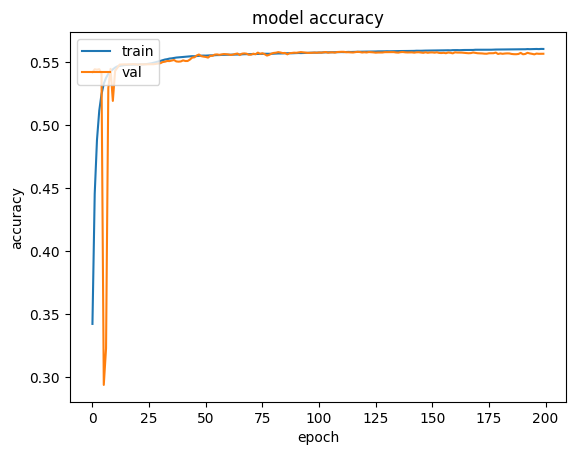

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

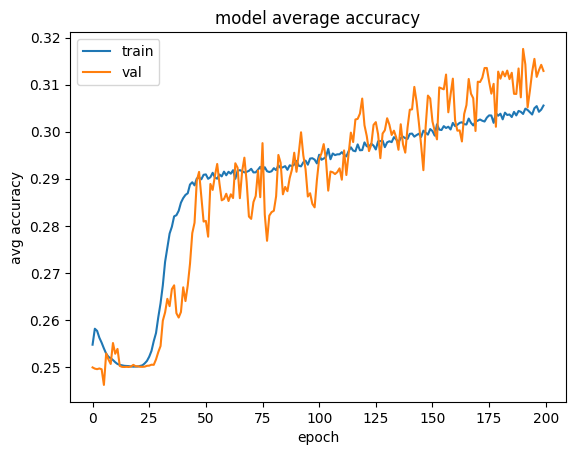

In [40]:
plt.plot(history.history['average_accuracy'])
plt.plot(history.history['val_average_accuracy'])
plt.title('model average accuracy')
plt.ylabel('avg accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

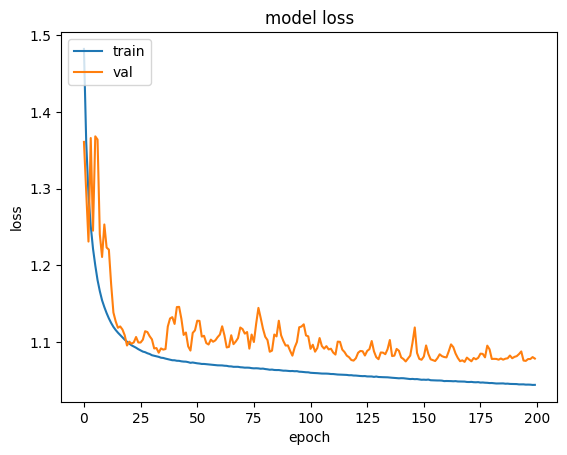

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


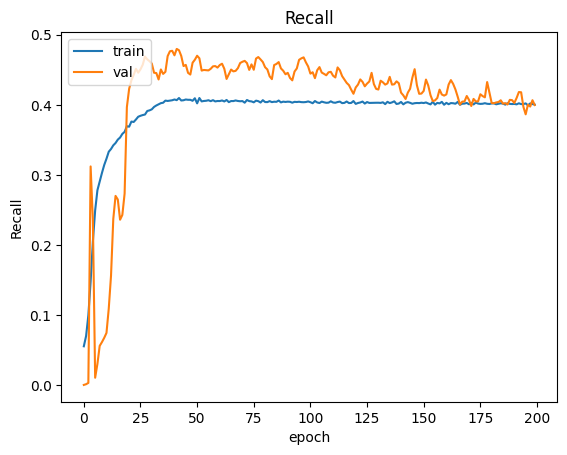

In [42]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()